# Part 1
## (a)  Algorithm implementation

### 1. Load the original data

In [28]:
# import necessary packages
import os
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# basic config setting for visualization
sns.set(style = "whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [10, 6]

In [29]:
# data dir
data_path = "./PA-1-data-text/"

# load data from text txt file
def load_data(file_prefix):
    sampx = np.loadtxt(os.path.join(data_path, f"{file_prefix}_sampx.txt"))
    sampy = np.loadtxt(os.path.join(data_path, f"{file_prefix}_sampy.txt"))
    polyx = np.loadtxt(os.path.join(data_path, f"{file_prefix}_polyx.txt"))
    polyy = np.loadtxt(os.path.join(data_path, f"{file_prefix}_polyy.txt"))
    thtrue = np.loadtxt(os.path.join(data_path, f"{file_prefix}_thtrue.txt"))
    return sampx, sampy, polyx, polyy, thtrue

FILE_PREFIX = "polydata_data" # file_prefix
data_files = [FILE_PREFIX]
datasets = {}
for file_prefix in data_files:
    datasets[file_prefix] = load_data(file_prefix)


In [30]:
# show data info
print(datasets.keys())
for name, data in datasets.items():
    sampx, sampy, polyx, polyy, thtrue = data
    print(f"dataset: {name}")
    print(f"num of samples: {len(sampx)}")
    print(f"num of test points: {len(polyx)}")
    print(f"num of real parameter: {len(thtrue)}")
    print()

dict_keys(['polydata_data'])
dataset: polydata_data
num of samples: 50
num of test points: 100
num of real parameter: 6



- define `polynomial_features` function for convert input `x` into presentation-style features

In [31]:
def polynomial_features(x, degree):
    """
    Convert input `x` into presentation-style features
    Phi: Feature Matrix (degree+1, n)
    """
    n = len(x)
    Phi = np.zeros((degree+1, n))
    for d in range(degree+1):
        Phi[d, :] = x ** d
    return Phi

# Test feature transformation
x_test = np.array([1, 2, 3])
degree = 3
Phi_test = polynomial_features(x_test, degree)
print("input x:", x_test)
print("Polynomial characteristic matrix (3 degree):")
print(Phi_test)

input x: [1 2 3]
Polynomial characteristic matrix (3 degree):
[[ 1.  1.  1.]
 [ 1.  2.  3.]
 [ 1.  4.  9.]
 [ 1.  8. 27.]]


### 2. code for Regression algorithm func
#### 2.1 Least-Squares(LS)

In [32]:
# Least-Squares(LS)
def least_squares(Phi, y):
    """
    Least-Squares(LS)

    func parameter:
    Phi: feature matrix (D, n) (dim, num of samples)
    y: target value (n,)

    theta: parameter estimation(D,)
    """
    # formula: theta = (Phi * Phi^T)^(-1) * Phi * y
    n = Phi.shape[1]
    Phi_matrix = Phi  # D x n

    # calculation (Phi * Phi^T)
    A = np.dot(Phi_matrix, Phi_matrix.T)

    # calculation (Phi * y)
    b = np.dot(Phi_matrix, y)

    # solve theta = A^(-1) * b
    theta = np.linalg.solve(A, b)

    return theta

# simple test
D = rd.randint(1, 5)
n = rd.randint(D, 10)
print(f"D: {D}, n: {n}")

Phi = np.random.randn(D, n)
print(f"random feature matrix:\n{Phi}")

y = np.random.randn(n)
print(f"random target value: {y}")

theta_hat = least_squares(Phi, y)
print(f"theta_hat: {theta_hat}")

D: 1, n: 2
random feature matrix:
[[1.13022819 0.37311891]]
random target value: [-0.38647295 -1.15877024]
theta_hat: [-0.61354029]


#### 2.2 Regularized_Least_Squares(RLS)

In [33]:
def regularized_least_squares(Phi, y, lambda_val):
    """
    Regularized_Least_Squares(RLS)

    func parameter:
    Phi: feature matrix (D, n)
    y: target value (n,)
    lambda_val: regularization parameter

    return:
    theta: parameter estimation (D,)
    """
    D, n = Phi.shape

    # formula: theta = (Phi * Phi^T + lambda * I)^(-1) * Phi * y
    A = np.dot(Phi, Phi.T) + lambda_val * np.eye(D)
    b = np.dot(Phi, y)

    theta = np.linalg.solve(A, b)

    return theta

# simple test
D = rd.randint(1, 5)
n = rd.randint(D, 10)
print(f"D: {D}, n: {n}")

Phi = np.random.randn(D, n)
print(f"random feature matrix:\n{Phi}")

y = np.random.randn(n)
print(f"random target value: {y}")

lambda_val = rd.uniform(0.01, 0.7)
print(f"regularization parameter: {lambda_val}")
theta_hat = regularized_least_squares(Phi, y, lambda_val)
print(f"theta_hat: {theta_hat}")


D: 4, n: 7
random feature matrix:
[[ 0.56611283 -0.70445345 -1.3779393  -0.35311665 -0.46146572  0.06665728
  -0.17628566]
 [ 1.20089277  0.69839894 -0.17162884 -0.90718658  1.18862573  0.78553212
   2.65601009]
 [ 0.26348604  1.64177112  0.4608163   0.08592347 -1.50995728  0.72150246
  -0.84341992]
 [-0.51332541 -0.0435368  -0.27530091 -1.56306679 -0.79563099  0.9305844
   0.67776741]]
random target value: [ 0.69844026  0.17360206  0.66228451  0.24112216 -0.16820509  1.16476865
 -0.24574769]
regularization parameter: 0.5102034859827836
theta_hat: [-0.04067727  0.1315195   0.3452051  -0.08338233]


#### 2.3 L1-regularized - LASSO Regression(using coordinate descent)

In [34]:
def lasso_regression(Phi, y, lambda_val, max_iter = 1000, tol = 1e-4):
    """
    LASSO Regression(using coordinate descent)

    func parameter:
    Phi: feature matrix (D, n)
    y: target value (n,)
    lambda_val:  regularization parameter
    max_iter: maximum number of iterations
    tol: Convergence limit

    return:
    theta: parameter estimation (D,)
    """
    D, n = Phi.shape
    theta = np.zeros(D)  # initialize paramter

    # pre calculation
    Phi_squared = np.sum(Phi**2, axis=1)

    for iteration in range(max_iter):
        theta_old = theta.copy()

        # coordinate descent: update one parameter of one iteration
        for j in range(D):
            # calculate residuals
            r = y - np.dot(Phi.T, theta) + Phi[j, :] * theta[j]

            # update parameter
            if Phi_squared[j] > 0:
                theta_j = np.dot(Phi[j, :], r) / Phi_squared[j]

                # using soft threshold
                if theta_j > lambda_val / Phi_squared[j]:
                    theta[j] = theta_j - lambda_val / Phi_squared[j]
                elif theta_j < -lambda_val / Phi_squared[j]:
                    theta[j] = theta_j + lambda_val / Phi_squared[j]
                else:
                    theta[j] = 0

        # check the convergence
        if np.max(np.abs(theta - theta_old)) < tol:
            break

    return theta

# simple test
D = rd.randint(1, 5)
n = rd.randint(D, 10)
print(f"D: {D}, n: {n}")

Phi = np.random.randn(D, n)
print(f"random feature matrix:\n{Phi}")

y = np.random.randn(n)
print(f"random target value: {y}")

lambda_val = rd.uniform(0.01, 0.7)
print(f"regularization parameter: {lambda_val:.4f}")
theta_hat = lasso_regression(Phi, y, lambda_val)
print(f"theta_hat: {theta_hat}")

D: 3, n: 5
random feature matrix:
[[-0.76966777  1.21217234  1.2334968  -1.57415529  0.63795294]
 [-2.04442302  1.06948089 -0.93376284  0.78420819 -0.61487576]
 [ 0.33289244 -1.38071702 -0.28080629 -0.05981726  0.96117377]]
random target value: [ 1.79428084  0.58068954  0.29765045 -1.02811577 -1.41859646]
regularization parameter: 0.5894
theta_hat: [-0.0695996  -0.70916677 -0.96117443]


#### 2.4 Robust Regression(RR)

In [35]:
def robust_regression(Phi, y, max_iter=100, tol=1e-4):
    """
    Robust regression (using iteratively reweighted least squares)

    func parameters:
    Phi: feature matrix (D, n)
    y: target value (n,)
    max_iter: Maximum number of iterations
    tol: Convergence tolerance

    Returns:
    theta: parameter estimation (D,)
    """

    # initialize variable
    D, n = Phi.shape
    theta = np.zeros(D)
    weights = np.ones(n)

    for iteration in range(max_iter):
        theta_old = theta.copy()

        #  reweighted least squares
        # W = diag(weights)
        # theta = (Phi * W * Phi^T)^(-1) * Phi * W * y
        W_sqrt = np.sqrt(weights)
        Phi_weighted = Phi * W_sqrt
        y_weighted = y * W_sqrt

        A = np.dot(Phi_weighted, Phi_weighted.T)
        b = np.dot(Phi_weighted, y_weighted)

        theta = np.linalg.solve(A, b)

        # update weight by residual
        residuals = np.abs(y - np.dot(Phi.T, theta))
        weights = 1 / np.maximum(residuals, 1e-10)  # avoid division by zero

        # check convergence
        if np.max(np.abs(theta - theta_old)) < tol:
            break

    return theta

# simple test
D = rd.randint(1, 5)
n = rd.randint(D, 10)
print(f"D: {D}, n: {n}")

Phi = np.random.randn(D, n)
print(f"random feature matrix:\n{Phi}")

y = np.random.randn(n)
print(f"random target value: {y}")

theta_hat = robust_regression(Phi, y)
print(f"theta_hat: {theta_hat}")

D: 2, n: 2
random feature matrix:
[[0.19033698 0.13575383]
 [0.60808966 0.70498131]]
random target value: [ 0.36092338 -1.46696789]
theta_hat: [22.20441893 -6.35662636]


#### 2.5 Byesian Regression

In [36]:
def bayesian_regression(Phi, y, alpha=1.0, sigma2=5.0):
    """
    Byesian Regression

    fun parameters:
    Phi: feature matrix (D, n)
    y: target value (n,)
    alpha: prior accuracy
    sigma2: noise variance

    return:
    theta_mean: posterior mean (D,)
    theta_cov: posterior covariance (D, D)
    """
    D, n = Phi.shape

    # Calculate the posterior distribution parameters
    # Sigma_theta = (alpha * I + (1/sigma2) * Phi * Phi^T)^(-1)
    # mu_theta = (1/sigma2) * Sigma_theta * Phi * y

    A = alpha * np.eye(D) + (1/sigma2) * np.dot(Phi, Phi.T)
    Sigma_theta = np.linalg.inv(A)
    mu_theta = (1/sigma2) * np.dot(Sigma_theta, np.dot(Phi, y))

    return mu_theta, Sigma_theta

# simple test
D = rd.randint(1, 5)
n = rd.randint(D, 10)
print(f"D: {D}, n: {n}")

Phi = np.random.randn(D, n)
print(f"random feature matrix:\n{Phi}")

y = np.random.randn(n)
print(f"random target value: {y}")

theta_hat = bayesian_regression(Phi, y)
print(f"theta_hat: {theta_hat}")

D: 4, n: 9
random feature matrix:
[[ 0.89262947 -0.10525713 -0.95534644 -0.41476463 -1.39874088 -0.34408054
   0.75078589 -0.32762518 -0.86159805]
 [-0.2581848   0.46095562 -1.34938997 -1.01907279  0.12701224 -1.24944372
   1.94511561 -0.15333646 -0.90698723]
 [-0.81735416 -0.48312268 -0.56982835 -2.09159967  1.26374053 -0.01548334
  -0.02737645  0.81787351 -1.05460447]
 [-0.75832712  0.45741565 -0.06437805  0.34490234 -0.08008734 -0.24138013
   1.43351549  1.06579371 -2.49875914]]
random target value: [ 1.48032856  2.15872852  1.23177838 -0.21432448 -0.68919421  0.72783311
 -0.61906936  0.35615983 -0.02188087]
theta_hat: (array([ 0.07867956, -0.20407229, -0.16834347,  0.03669433]), array([[ 0.55326448, -0.15645926,  0.06829357, -0.04106037],
       [-0.15645926,  0.46347928, -0.10654677, -0.1158161 ],
       [ 0.06829357, -0.10654677,  0.40075857, -0.05346016],
       [-0.04106037, -0.1158161 , -0.05346016,  0.38130816]]))


### 3. Test function(optional)

In [37]:
# prepare the evaluation code
def mean_squared_error(y_true, y_pred):
    """Computes the mean squared error"""
    return np.mean((y_true - y_pred)**2)

def mean_absolute_error(y_true, y_pred):
    """Computes the mean absolute error"""
    return np.mean(np.abs(y_true - y_pred))

def r_squared(y_true, y_pred):
    """conculate R² score"""
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

In [38]:
# preparation for me
def predict(Phi, theta):
    """
    predict function

    func parameter:
    Phi: feature matrix (D, n)
    theta: parameter vector (D,)

    return:
    y_pred: predict value (n,)
    """
    return np.dot(Phi.T, theta)

def bayesian_predict(Phi_test, mu_theta, Sigma_theta):
    """
    bayesian predict function

    func parameters:
    Phi_test: test feature matrix (D, m)
    mu_theta: posterior mean (D,)
    Sigma_theta: posterior covariance (D, D)

    return:
    y_mean: predict mean (m,)
    y_std: predict std (m,)
    """
    y_mean = np.dot(Phi_test.T, mu_theta)
    y_var = np.diag(np.dot(Phi_test.T, np.dot(Sigma_theta, Phi_test)))
    y_std = np.sqrt(y_var)

    return y_mean, y_std

### 4.Test about 5 degree(optional)

In [39]:
DEGREE = 5

results = {}

for name, data in datasets.items():
    sampx, sampy, polyx, polyy, thtrue = data

    # create feature matrix of both train data and test data
    Phi_train = polynomial_features(sampx, DEGREE)
    Phi_test = polynomial_features(polyx, DEGREE)

    results[name] = {
        'true_params': thtrue,
        'predictions': {},
        'metrics': {},
        'params': {}
    }

    # 1. Least-Square Regression(LS)
    theta_ls = least_squares(Phi_train, sampy)
    y_pred_ls = predict(Phi_test, theta_ls)

    results[name]['predictions']['LS'] = y_pred_ls
    results[name]['params']['LS'] = theta_ls
    results[name]['metrics']['LS'] = {
        'MSE': mean_squared_error(polyy, y_pred_ls),
        'MAE': mean_absolute_error(polyy, y_pred_ls),
        'R2': r_squared(polyy, y_pred_ls)
    }

    # 2. Regularized LS (RLS)
    theta_rls = regularized_least_squares(Phi_train, sampy, lambda_val = 0.1)
    y_pred_rls = predict(Phi_test, theta_rls)

    results[name]['predictions']['RLS'] = y_pred_rls
    results[name]['params']['RLS'] = theta_rls
    results[name]['metrics']['RLS'] = {
        'MSE': mean_squared_error(polyy, y_pred_rls),
        'MAE': mean_absolute_error(polyy, y_pred_rls),
        'R2': r_squared(polyy, y_pred_rls)
    }

    # 3. Lasso Regression (lambda=0.1)
    theta_lasso = lasso_regression(Phi_train, sampy, lambda_val=0.1)
    y_pred_lasso = predict(Phi_test, theta_lasso)

    results[name]['predictions']['LASSO'] = y_pred_lasso
    results[name]['params']['LASSO'] = theta_lasso
    results[name]['metrics']['LASSO'] = {
        'MSE': mean_squared_error(polyy, y_pred_lasso),
        'MAE': mean_absolute_error(polyy, y_pred_lasso),
        'R2': r_squared(polyy, y_pred_lasso)
    }

    # 4. Robust Regression
    theta_rr = robust_regression(Phi_train, sampy)
    y_pred_rr = predict(Phi_test, theta_rr)

    results[name]['predictions']['RR'] = y_pred_rr
    results[name]['params']['RR'] = theta_rr
    results[name]['metrics']['RR'] = {
        'MSE': mean_squared_error(polyy, y_pred_rr),
        'MAE': mean_absolute_error(polyy, y_pred_rr),
        'R2': r_squared(polyy, y_pred_rr)
    }

    # 5. Bayesian Regression
    theta_bayes, Sigma_bayes = bayesian_regression(Phi_train, sampy, alpha=1.0, sigma2=5.0)
    y_pred_bayes, y_std_bayes = bayesian_predict(Phi_test, theta_bayes, Sigma_bayes)

    results[name]['predictions']['BR'] = y_pred_bayes
    results[name]['predictions']['BR_std'] = y_std_bayes
    results[name]['params']['BR'] = theta_bayes
    results[name]['metrics']['BR'] = {
        'MSE': mean_squared_error(polyy, y_pred_bayes),
        'MAE': mean_absolute_error(polyy, y_pred_bayes),
        'R2': r_squared(polyy, y_pred_bayes)
    }

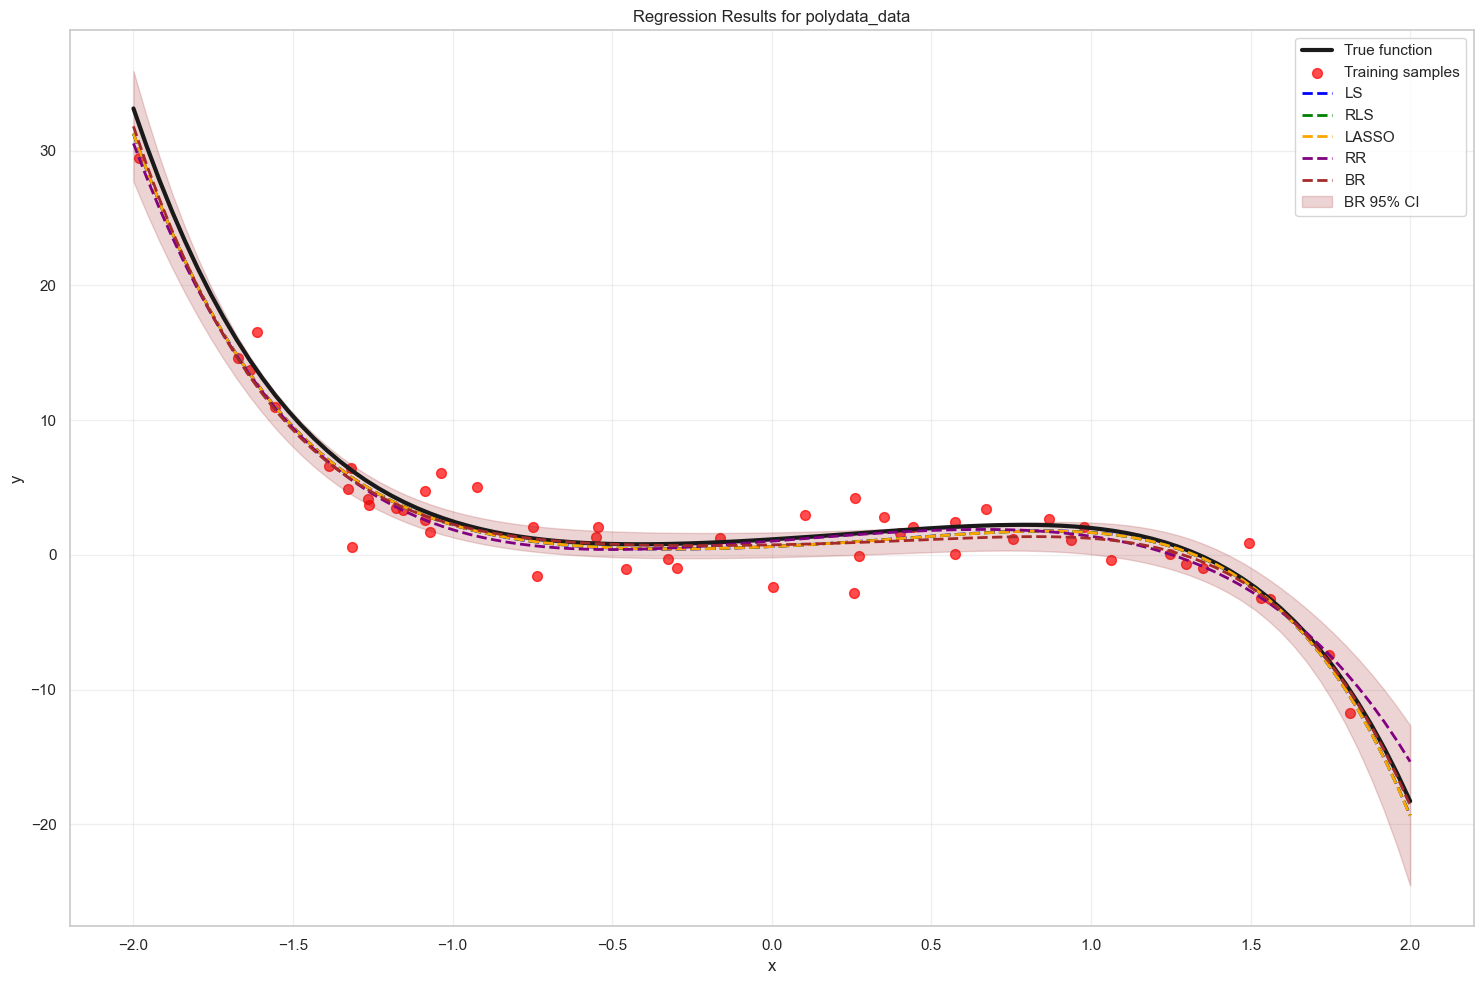

In [40]:
# plot figure for a simpletest
def plot_results(data, results, dataset_name):
    sampx, sampy, polyx, polyy, thtrue = data

    plt.figure(figsize = (15, 10))

    plt.plot(polyx, polyy, 'k-', linewidth = 3, label = 'True function')

    plt.scatter(sampx, sampy, color = 'red', s = 50, alpha = 0.7, label = 'Training samples')

    methods = ['LS', 'RLS', 'LASSO', 'RR', 'BR']
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    for method, color in zip(methods, colors):
        y_pred = results[dataset_name]['predictions'][method]
        plt.plot(polyx, y_pred, '--', linewidth = 2, color = color, label = method)

    y_pred_br = results[dataset_name]['predictions']['BR']
    y_std_br = results[dataset_name]['predictions']['BR_std']
    plt.fill_between(polyx, y_pred_br - 2*y_std_br, y_pred_br + 2*y_std_br,
                    color = 'brown', alpha = 0.2, label = 'BR 95% CI')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Regression Results for {dataset_name}')
    plt.legend()
    plt.grid(True, alpha = 0.3)
    plt.tight_layout()
    plt.savefig("./images/part1/a_demo.png", dpi=300, bbox_inches='tight')
    plt.show()

for name, data in datasets.items():
    plot_results(data, results, name)

## (b) Estimation and Error Analysis of Fifth-Degree Polynomial
### 1. Algorithm execution to get results

In [41]:
DEGREE = 5

dataset_name = list(datasets.keys())[0]
sampx, sampy, polyx, polyy, thtrue = datasets[dataset_name]

# create feature matrix of both train data and test data
Phi_train = polynomial_features(sampx, DEGREE)
Phi_test = polynomial_features(polyx, DEGREE)

# Hypter-parameter setting
lambda_rls = 0.1  # RLS regularized parameter
lambda_lasso = 0.05  # LASSO regularized parameter
alpha_br = 1.0  # bayesian regression prior accuracy
sigma2_br = 5.0  # Bayesian Noise Regression

results = {
    'true_params': thtrue,
    'predictions': {},
    'metrics': {},
    'params': {}
}

# 1. Least-Square Regression(LS)
theta_ls = least_squares(Phi_train, sampy)
y_pred_ls = predict(Phi_test, theta_ls)

results['predictions']['LS'] = y_pred_ls
results['params']['LS'] = theta_ls
results['metrics']['LS'] = {
    'MSE': mean_squared_error(polyy, y_pred_ls)
}

# 2. Regularized LS (RLS)
theta_rls = regularized_least_squares(Phi_train, sampy, lambda_rls)
y_pred_rls = predict(Phi_test, theta_rls)

results['predictions']['RLS'] = y_pred_rls
results['params']['RLS'] = theta_rls
results['metrics']['RLS'] = {
    'MSE': mean_squared_error(polyy, y_pred_rls)
}

# 3. Lasso Regression (lambda = 0.05)
theta_lasso = lasso_regression(Phi_train, sampy, lambda_lasso)
y_pred_lasso = predict(Phi_test, theta_lasso)

results['predictions']['LASSO'] = y_pred_lasso
results['params']['LASSO'] = theta_lasso
results['metrics']['LASSO'] = {
    'MSE': mean_squared_error(polyy, y_pred_lasso)
}

# 4. Robust Regression (RR)
theta_rr = robust_regression(Phi_train, sampy)
y_pred_rr = predict(Phi_test, theta_rr)

results['predictions']['RR'] = y_pred_rr
results['params']['RR'] = theta_rr
results['metrics']['RR'] = {
    'MSE': mean_squared_error(polyy, y_pred_rr)
}

# 5. Bayesian Regression (BR)
theta_bayes, Sigma_bayes = bayesian_regression(Phi_train, sampy, alpha_br, sigma2_br)
y_pred_bayes, y_std_bayes = bayesian_predict(Phi_test, theta_bayes, Sigma_bayes)

results['predictions']['BR'] = y_pred_bayes
results['predictions']['BR_std'] = y_std_bayes
results['params']['BR'] = theta_bayes
results['metrics']['BR'] = {
    'MSE': mean_squared_error(polyy, y_pred_bayes)
}

# Show the mse result
print("Mean square error of 5th-degree polynomial estimation (MSE):")
for method, metrics in results['metrics'].items():
    print(f"{method}: {metrics['MSE']:.4f}")

Mean square error of 5th-degree polynomial estimation (MSE):
LS: 0.4086
RLS: 0.4082
LASSO: 0.4100
RR: 0.7680
BR: 0.4592


### 2.Results Visualization

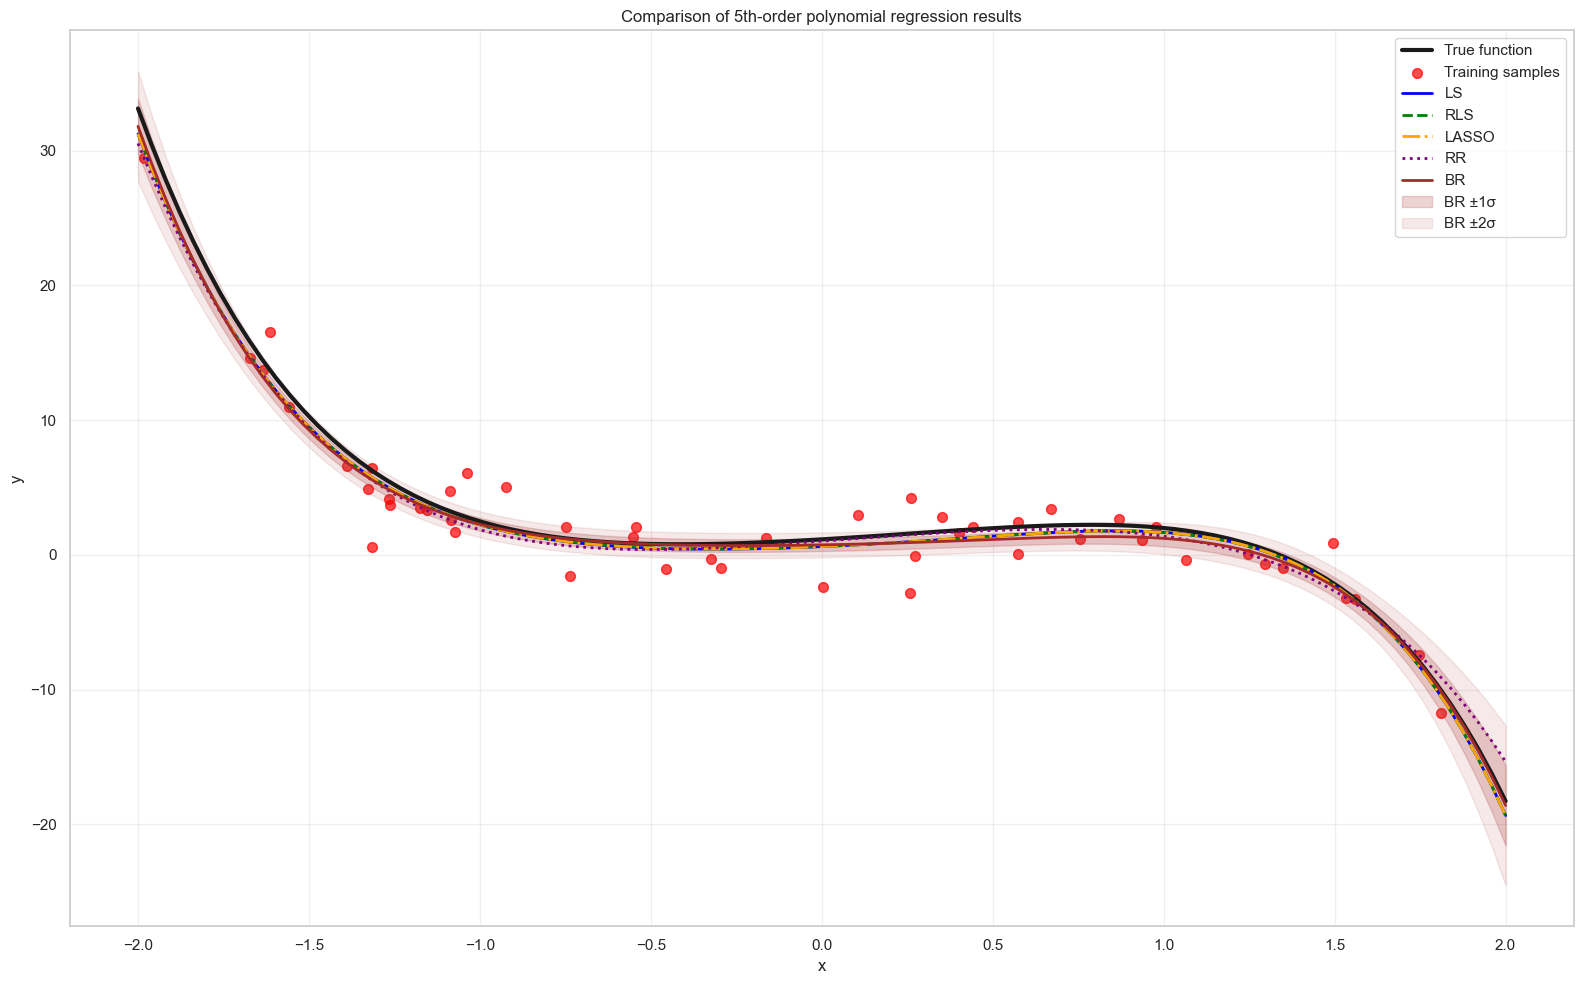

In [42]:
# set img size
plt.figure(figsize = (16, 10))

# plot true func
plt.plot(polyx, polyy, 'k-', linewidth = 3, label = 'True function')

# plot sample points
plt.scatter(sampx, sampy, color = 'red', s = 50, alpha = 0.7, label = 'Training samples')

methods = ['LS', 'RLS', 'LASSO', 'RR', 'BR']
colors = ['blue', 'green', 'orange', 'purple', 'brown']
linestyles = ['-', '--', '-.', ':', '-']

for method, color, linestyle in zip(methods, colors, linestyles):
    y_pred = results['predictions'][method]
    plt.plot(polyx, y_pred, linestyle = linestyle, linewidth = 2, color = color, label = method)

# BR processing
y_pred_br = results['predictions']['BR']
y_std_br = results['predictions']['BR_std']
plt.fill_between(polyx, y_pred_br - y_std_br, y_pred_br + y_std_br,
                color = 'brown', alpha = 0.2, label = 'BR ±1σ')
plt.fill_between(polyx, y_pred_br - 2*y_std_br, y_pred_br + 2*y_std_br,
                color = 'brown', alpha = 0.1, label = 'BR ±2σ')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of 5th-order polynomial regression results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./images/part1/b_5th_degree_poly_fit.png', dpi=300, bbox_inches='tight')
plt.show()



### 3.Comparison of parameter estimates with true parameters

/var/folders/q_/8yf60dmj12zb6s7t_hk0t7y40000gn/T/ipykernel_43597/3472528498.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(x_pos, params, 'o--', color=color, markersize=6, label=method, linestyle=linestyle)


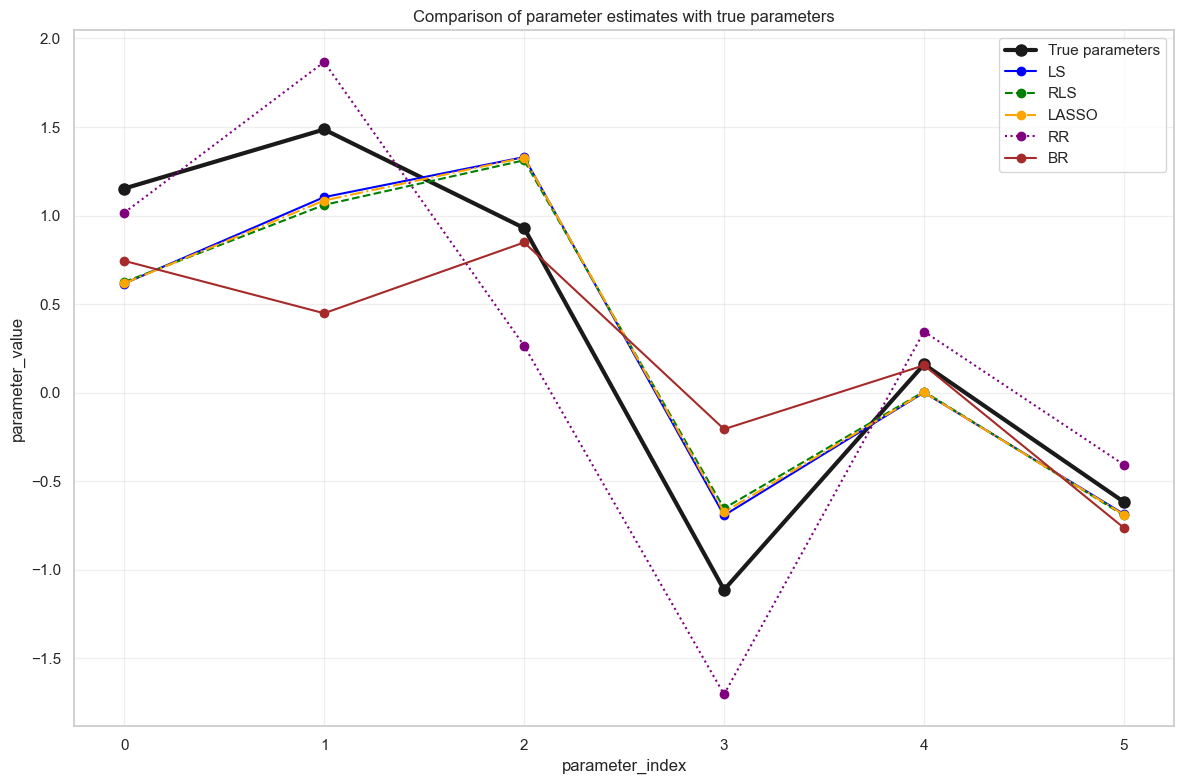

In [43]:
plt.figure(figsize=(12, 8))

# true parameters
x_pos = np.arange(len(thtrue))
plt.plot(x_pos, thtrue, 'ko-', linewidth=3, markersize=8, label='True parameters')

# parameter estimates
for method, color, linestyle in zip(methods, colors, linestyles):
    params = results['params'][method]
    plt.plot(x_pos, params, 'o--', color=color, markersize=6, label=method, linestyle=linestyle)

plt.xlabel('parameter_index')
plt.ylabel('parameter_value')
plt.title('Comparison of parameter estimates with true parameters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./images/part1/b_parameter_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.Hyperparameter selection analysis

RLS (λ=1e-05): MSE = 0.408644
RLS (λ=0.0001): MSE = 0.408643
RLS (λ=0.001): MSE = 0.408639
RLS (λ=0.01): MSE = 0.408598
RLS (λ=0.1): MSE = 0.408237
RLS (λ=1.0): MSE = 0.408633
RLS (λ=10.0): MSE = 0.557904


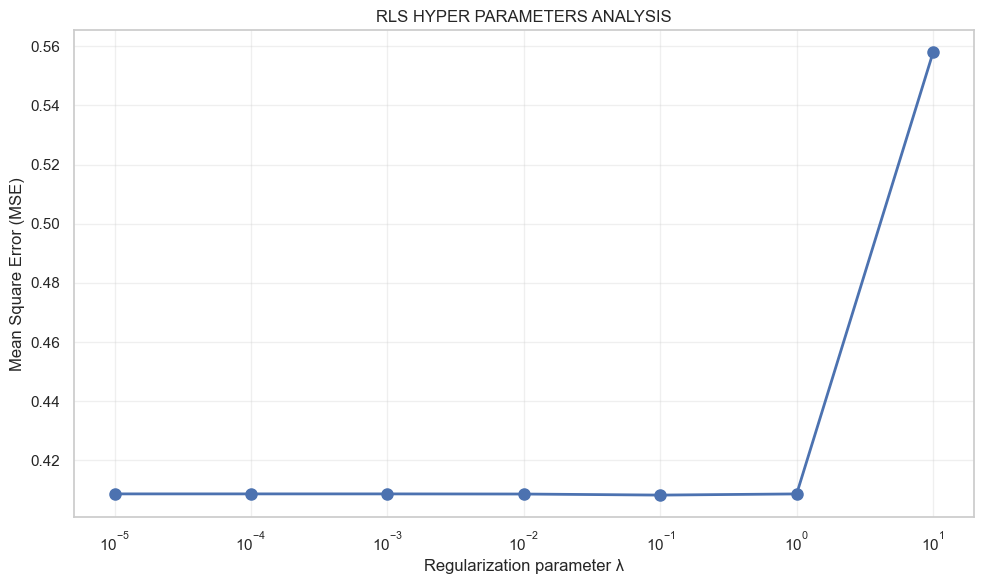

LASSO (λ=1e-05): MSE = 0.407506
LASSO (λ=0.0001): MSE = 0.407511
LASSO (λ=0.001): MSE = 0.407555
LASSO (λ=0.01): MSE = 0.407998
LASSO (λ=0.05): MSE = 0.410043
LASSO (λ=0.1): MSE = 0.412683
LASSO (λ=0.5): MSE = 0.436309


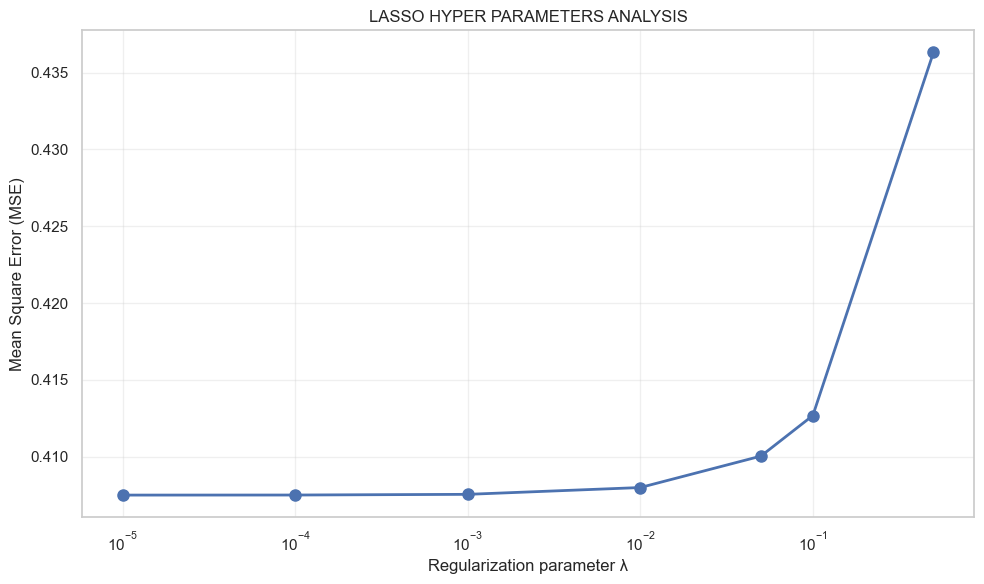


The Best Hyper parameter about λ:
RLS: 0.1 (MSE = 0.408237)
LASSO: 1e-05 (MSE = 0.407506)

using the best λ to train the model again:
RLS (the best λ=0.1): MSE = 0.408237
LASSO (the best λ=1e-05): MSE = 0.407506


In [44]:
# RLS hyperparameter selection
lambda_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
rls_mses = []

for lambda_val in lambda_values:
    theta_rls_tmp = regularized_least_squares(Phi_train, sampy, lambda_val)
    y_pred_rls_tmp = predict(Phi_test, theta_rls_tmp)
    mse = mean_squared_error(polyy, y_pred_rls_tmp)
    rls_mses.append(mse)
    print(f"RLS (λ={lambda_val}): MSE = {mse:.6f}")

# plot RLS HYPER PARAMETERS ANALYSIS image
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, rls_mses, 'o-', linewidth=2, markersize=8)
plt.xlabel('Regularization parameter λ')
plt.ylabel('Mean Square Error (MSE)')
plt.title('RLS HYPER PARAMETERS ANALYSIS')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./images/part1/b_rls_hyperparameter.png', dpi=300, bbox_inches='tight')
plt.show()

# LASSO hyperparameter selection
lambda_lasso_values = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5]
lasso_mses = []

for lambda_val in lambda_lasso_values:
    theta_lasso_tmp = lasso_regression(Phi_train, sampy, lambda_val)
    y_pred_lasso_tmp = predict(Phi_test, theta_lasso_tmp)
    mse = mean_squared_error(polyy, y_pred_lasso_tmp)
    lasso_mses.append(mse)
    print(f"LASSO (λ={lambda_val}): MSE = {mse:.6f}")

# plot LASSO HYPER PARAMETERS ANALYSIS
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_lasso_values, lasso_mses, 'o-', linewidth=2, markersize=8)
plt.xlabel('Regularization parameter λ')
plt.ylabel('Mean Square Error (MSE)')
plt.title('LASSO HYPER PARAMETERS ANALYSIS')
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.savefig('./images/part1/b_lasso_hyperparameter.png', dpi=300, bbox_inches='tight')
plt.show()

# 选择最佳超参数
best_lambda_rls = lambda_values[np.argmin(rls_mses)]
best_lambda_lasso = lambda_lasso_values[np.argmin(lasso_mses)]

print(f"\nThe Best Hyper parameter about λ:")
print(f"RLS: {best_lambda_rls} (MSE = {min(rls_mses):.6f})")
print(f"LASSO: {best_lambda_lasso} (MSE = {min(lasso_mses):.6f})")

# 使用最佳超参数重新训练
print("\nusing the best λ to train the model again:")

# RLS使用最佳超参数
theta_rls_best = regularized_least_squares(Phi_train, sampy, best_lambda_rls)
y_pred_rls_best = predict(Phi_test, theta_rls_best)
mse_rls_best = mean_squared_error(polyy, y_pred_rls_best)
print(f"RLS (the best λ={best_lambda_rls}): MSE = {mse_rls_best:.6f}")

# LASSO使用最佳超参数
theta_lasso_best = lasso_regression(Phi_train, sampy, best_lambda_lasso)
y_pred_lasso_best = predict(Phi_test, theta_lasso_best)
mse_lasso_best = mean_squared_error(polyy, y_pred_lasso_best)
print(f"LASSO (the best λ={best_lambda_lasso}): MSE = {mse_lasso_best:.6f}")

## c.Effect of Training Data Size on Model Performance

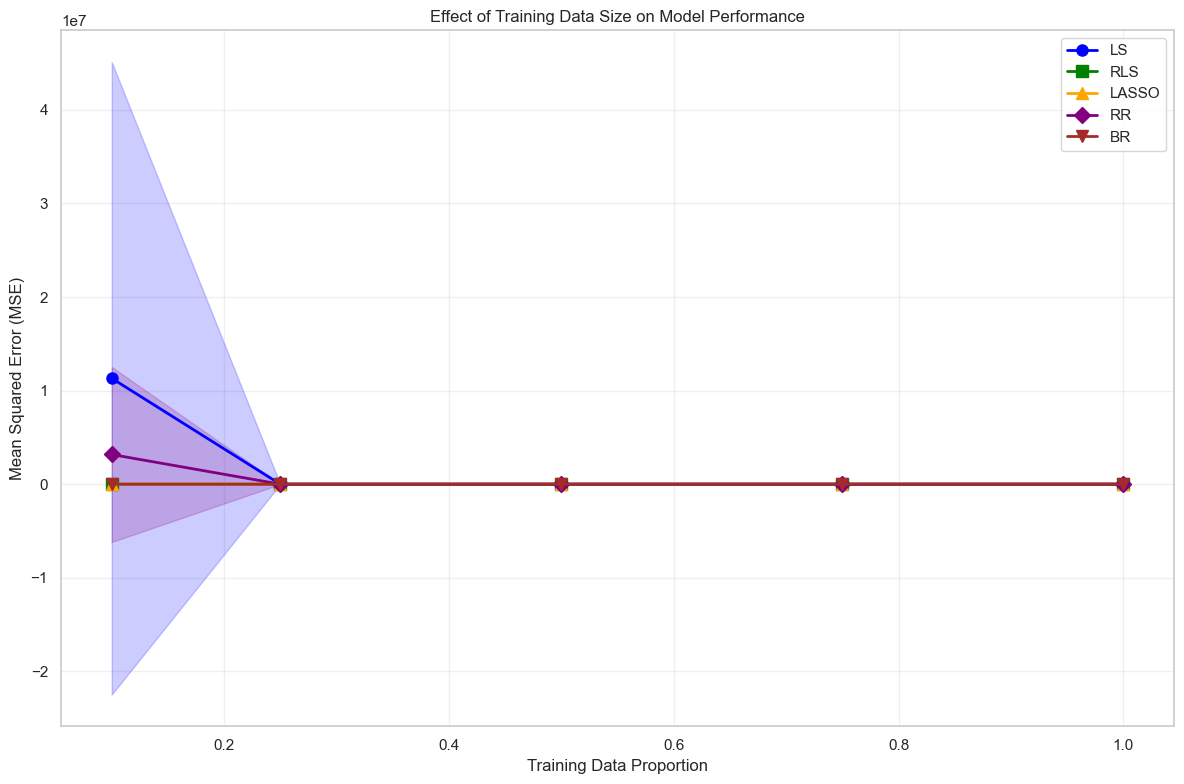

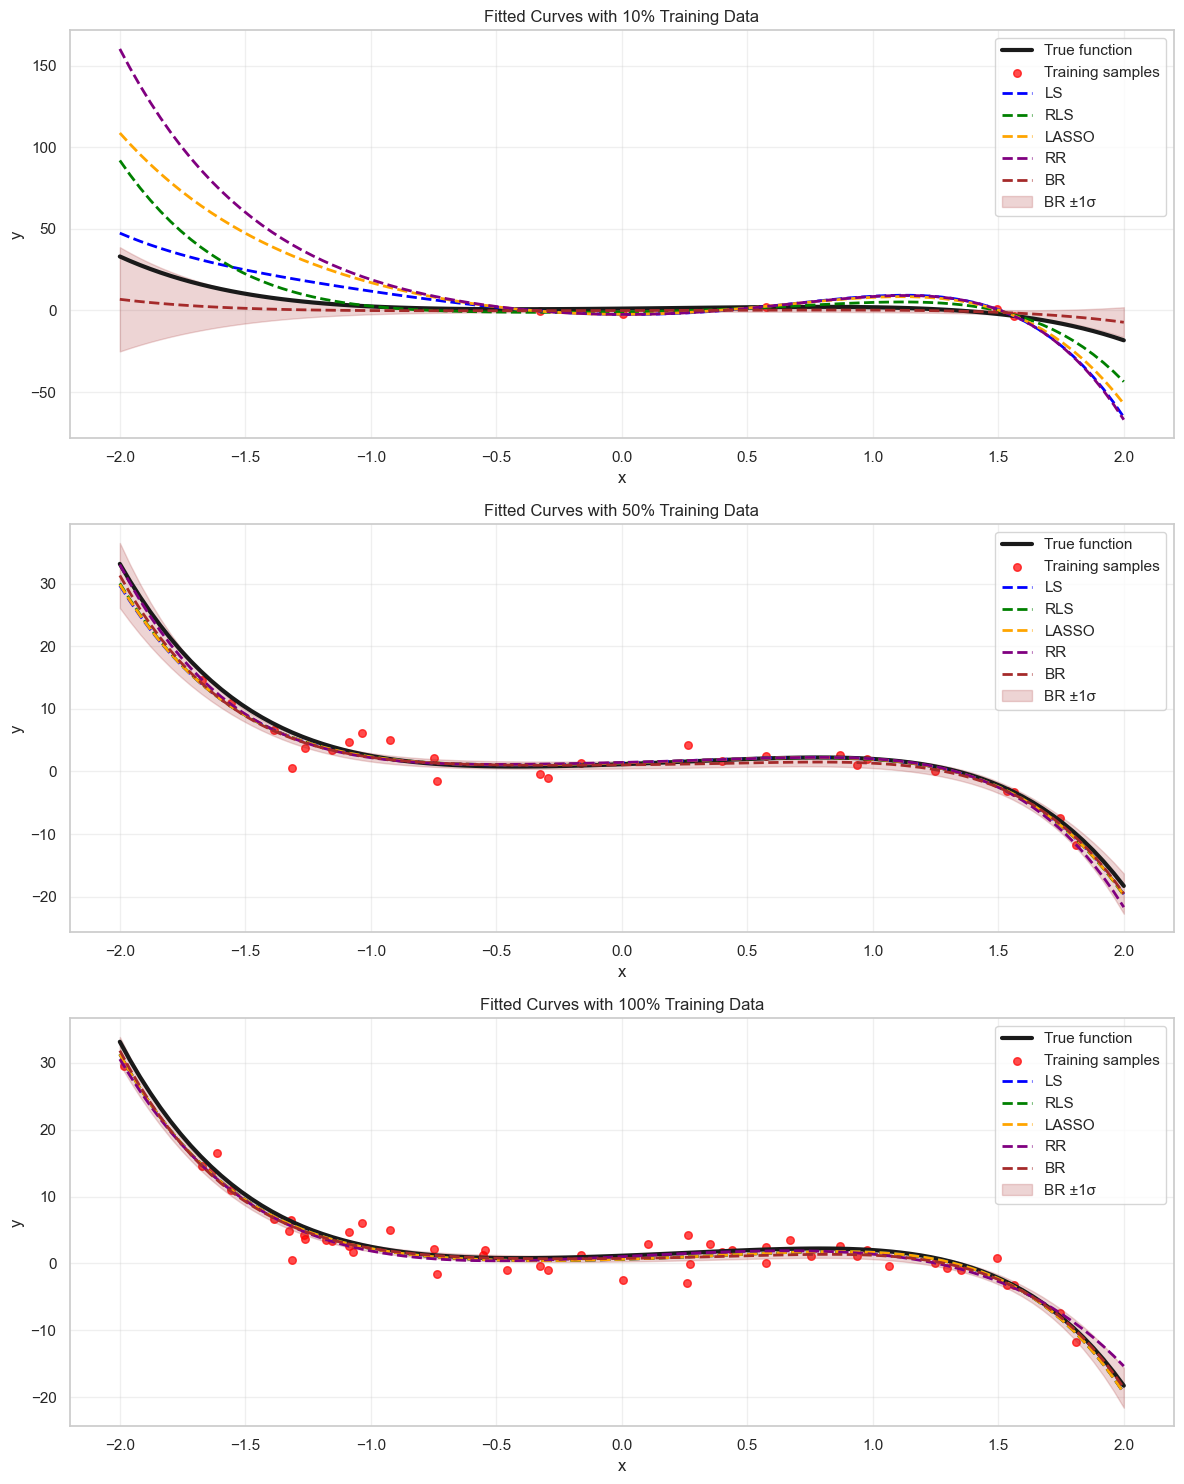

Summary of MSE results across different training sizes:
Training Proportion	LS		RLS		LASSO		RR		BR
0.10	11316729.3243±33795974.1902	122.6748±129.4007	550.5003±763.3320	3173572.1993±9351424.4160	16.2487±25.5925
0.25	60.1093±91.1216	12.2303±17.7789	38.0039±64.9274	53.4922±81.8486	2.5124±2.0137
0.50	1.6669±1.9994	1.2277±1.1588	1.4966±1.6632	1.5816±0.8920	0.7726±0.3799
0.75	0.7136±0.2914	0.6987±0.2826	0.7021±0.2904	0.8569±0.3223	0.6966±0.2485
1.00	0.4086±0.0000	0.4082±0.0000	0.4100±0.0000	0.7680±0.0000	0.4592±0.0000


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Set random seed for reproducibility
np.random.seed(42)

# Define the training data proportions to test
train_proportions = [0.1, 0.25, 0.5, 0.75, 1.0]
n_repeats = 10  # Number of repetitions for each proportion to reduce randomness

# Initialize results storage
mse_results = {
    'LS': [],
    'RLS': [],
    'LASSO': [],
    'RR': [],
    'BR': []
}

# Hyperparameters (using the best ones from part b)
lambda_rls = 0.1
lambda_lasso = 0.05
alpha_br = 1.0
sigma2_br = 5.0

# Get the dataset
dataset_name = list(datasets.keys())[0]
sampx, sampy, polyx, polyy, thtrue = datasets[dataset_name]
n_samples = len(sampx)

# Create test feature matrix
Phi_test = polynomial_features(polyx, DEGREE)

# For each training proportion
for prop in train_proportions:
    n_train = int(prop * n_samples)

    # Initialize MSE storage for this proportion
    mse_temp = {
        'LS': [],
        'RLS': [],
        'LASSO': [],
        'RR': [],
        'BR': []
    }

    # Repeat multiple times to reduce randomness
    for repeat in range(n_repeats):
        # Randomly select training subset
        indices = np.random.choice(n_samples, n_train, replace=False)
        sampx_sub = sampx[indices]
        sampy_sub = sampy[indices]

        # Create training feature matrix
        Phi_train = polynomial_features(sampx_sub, DEGREE)

        # Train and evaluate each model
        # 1. Least Squares
        theta_ls = least_squares(Phi_train, sampy_sub)
        y_pred_ls = predict(Phi_test, theta_ls)
        mse_ls = mean_squared_error(polyy, y_pred_ls)
        mse_temp['LS'].append(mse_ls)

        # 2. Regularized Least Squares
        theta_rls = regularized_least_squares(Phi_train, sampy_sub, lambda_rls)
        y_pred_rls = predict(Phi_test, theta_rls)
        mse_rls = mean_squared_error(polyy, y_pred_rls)
        mse_temp['RLS'].append(mse_rls)

        # 3. LASSO
        theta_lasso = lasso_regression(Phi_train, sampy_sub, lambda_lasso)
        y_pred_lasso = predict(Phi_test, theta_lasso)
        mse_lasso = mean_squared_error(polyy, y_pred_lasso)
        mse_temp['LASSO'].append(mse_lasso)

        # 4. Robust Regression
        theta_rr = robust_regression(Phi_train, sampy_sub)
        y_pred_rr = predict(Phi_test, theta_rr)
        mse_rr = mean_squared_error(polyy, y_pred_rr)
        mse_temp['RR'].append(mse_rr)

        # 5. Bayesian Regression
        theta_bayes, Sigma_bayes = bayesian_regression(Phi_train, sampy_sub, alpha_br, sigma2_br)
        y_pred_bayes, _ = bayesian_predict(Phi_test, theta_bayes, Sigma_bayes)
        mse_br = mean_squared_error(polyy, y_pred_bayes)
        mse_temp['BR'].append(mse_br)

    # Calculate mean and std for each method
    for method in mse_results.keys():
        mean_mse = np.mean(mse_temp[method])
        std_mse = np.std(mse_temp[method])
        mse_results[method].append((mean_mse, std_mse))

# Plot the results
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'orange', 'purple', 'brown']
markers = ['o', 's', '^', 'D', 'v']

for i, method in enumerate(mse_results.keys()):
    means = [result[0] for result in mse_results[method]]
    stds = [result[1] for result in mse_results[method]]

    plt.plot(train_proportions, means, color=colors[i], marker=markers[i],
             linewidth=2, markersize=8, label=method)
    plt.fill_between(train_proportions,
                    [m - s for m, s in zip(means, stds)],
                    [m + s for m, s in zip(means, stds)],
                    color=colors[i], alpha=0.2)

plt.xlabel('Training Data Proportion')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of Training Data Size on Model Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./images/part1/c_training_size_effect.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot fitted curves for different training sizes
selected_proportions = [0.1, 0.5, 1.0]
fig, axes = plt.subplots(len(selected_proportions), 1, figsize=(12, 15))

for idx, prop in enumerate(selected_proportions):
    n_train = int(prop * n_samples)

    # Randomly select training subset
    indices = np.random.choice(n_samples, n_train, replace=False)
    sampx_sub = sampx[indices]
    sampy_sub = sampy[indices]

    # Create training feature matrix
    Phi_train = polynomial_features(sampx_sub, DEGREE)

    # Train models
    theta_ls = least_squares(Phi_train, sampy_sub)
    y_pred_ls = predict(Phi_test, theta_ls)

    theta_rls = regularized_least_squares(Phi_train, sampy_sub, lambda_rls)
    y_pred_rls = predict(Phi_test, theta_rls)

    theta_lasso = lasso_regression(Phi_train, sampy_sub, lambda_lasso)
    y_pred_lasso = predict(Phi_test, theta_lasso)

    theta_rr = robust_regression(Phi_train, sampy_sub)
    y_pred_rr = predict(Phi_test, theta_rr)

    theta_bayes, Sigma_bayes = bayesian_regression(Phi_train, sampy_sub, alpha_br, sigma2_br)
    y_pred_bayes, y_std_bayes = bayesian_predict(Phi_test, theta_bayes, Sigma_bayes)

    # Plot
    ax = axes[idx]
    ax.plot(polyx, polyy, 'k-', linewidth=3, label='True function')
    ax.scatter(sampx_sub, sampy_sub, color='red', s=30, alpha=0.7, label='Training samples')

    ax.plot(polyx, y_pred_ls, '--', linewidth=2, color='blue', label='LS')
    ax.plot(polyx, y_pred_rls, '--', linewidth=2, color='green', label='RLS')
    ax.plot(polyx, y_pred_lasso, '--', linewidth=2, color='orange', label='LASSO')
    ax.plot(polyx, y_pred_rr, '--', linewidth=2, color='purple', label='RR')
    ax.plot(polyx, y_pred_bayes, '--', linewidth=2, color='brown', label='BR')

    # Add confidence interval for Bayesian regression
    ax.fill_between(polyx, y_pred_bayes - y_std_bayes, y_pred_bayes + y_std_bayes,
                   color='brown', alpha=0.2, label='BR ±1σ')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Fitted Curves with {int(prop*100)}% Training Data')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./images/part1/c_fitted_curves_different_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary of results
print("Summary of MSE results across different training sizes:")
print("Training Proportion\tLS\t\tRLS\t\tLASSO\t\tRR\t\tBR")
for i, prop in enumerate(train_proportions):
    row = f"{prop:.2f}"
    for method in mse_results.keys():
        mean_mse, std_mse = mse_results[method][i]
        row += f"\t{mean_mse:.4f}±{std_mse:.4f}"
    print(row)

## Analysis of (c)
### 1. Robustness Analysis When Data Volume Is Small
![image_c1](./images/part1/c_training_size_effect.png)
Based on the results with 10% training data:
- **BR (Bayesian Regression)**: MSE = 16.2487 ± 25.5925
- **RLS (Regularized Least Squares)**: MSE = 122.6748 ± 129.4007
- **LASSO**: MSE = 550.5003 ± 763.3320
- **RR (Robust Regression)**: MSE = 3173572.1993 ± 9351424.4160
- **LS (Least Squares)**: MSE = 11316729.3243 ± 33795974.1902

#### Analysis Conclusions
- **Bayesian Regression (BR)** is the most robust when data volume is extremely small (10%), with an MSE much lower than other methods and a relatively small variance.
- **Regularized Least Squares (RLS)** also demonstrates good robustness, with a relatively low MSE.
- **LASSO** performs moderately when data volume is small—it is inferior to BR and RLS but far better than RR and LS.
- **Robust Regression (RR)** and **Least Squares (LS)** perform the worst when data volume is extremely small, with extremely high MSE and huge variance, indicating high sensitivity to reduced data volume.

#### Robustness Ranking
BR > RLS > LASSO > RR > LS


### 2. Overfitting Tendency Analysis
![image_c2](./images/part1/c_fitted_curves_different_sizes.png)

| Training Proportion | LS (MSE±STD)               | RLS (MSE±STD)              | LASSO (MSE±STD)             | RR (MSE±STD)                | BR (MSE±STD)              |
|:--------------------:|:---------------------------|:----------------------------|:-----------------------------|:----------------------------|:---------------------------|
| 0.10 | 11316729.3243±33795974.1902 | 122.6748±129.4007 | 550.5003±763.3320 | 3173572.1993±9351424.4160 | 16.2487±25.5925 |
| 0.25 | 60.1093±91.1216 | 12.2303±17.7789 | 38.0039±64.9274 | 53.4922±81.8486 | 2.5124±2.0137 |
| 0.50 | 1.6669±1.9994 | 1.2277±1.1588 | 1.4966±1.6632 | 1.5816±0.8920 | 0.7726±0.3799 |
| 0.75 | 0.7136±0.2914 | 0.6987±0.2826 | 0.7021±0.2904 | 0.8569±0.3223 | 0.6966±0.2485 |
| 1.00 | 0.4086±0.0000 | 0.4082±0.0000 | 0.4100±0.0000 | 0.7680±0.0000 | 0.4592±0.0000 |

By observing the changing trend of MSE as the volume of training data increases:
- **Least Squares (LS)**: When data volume increases from 10% to 25%, MSE drops drastically from 11316729 to 60.1093. This indicates that LS suffers from severe overfitting when data volume is small, and the overfitting phenomenon eases rapidly as data volume increases—making it the method most prone to overfitting.
- **Robust Regression (RR)**: When data volume increases from 10% to 25%, MSE drops drastically from 3173572 to 53.4922. It behaves similarly to LS and is prone to overfitting.
- **LASSO**: When data volume increases from 10% to 25%, MSE drops significantly (though less extremely than LS and RR) from 550.5003 to 38.0039. This indicates a certain tendency for overfitting, but it is partially controlled by L1 regularization.
- **Regularized Least Squares (RLS)**: When data volume increases from 10% to 25%, MSE drops moderately from 122.6748 to 12.2303. Overfitting is effectively controlled through L2 regularization.
- **Bayesian Regression (BR)**: When data volume increases from 10% to 25%, MSE drops relatively slightly from 16.2487 to 2.5124. This indicates that BR has the lowest tendency for overfitting, as it effectively constrains model complexity through prior distribution.

#### Overfitting Tendency Ranking
LS > RR > LASSO > RLS > BR


### 3. Comprehensive Analysis and Explanation
#### Why BR Is the Most Robust When Data Volume Is Small:
Bayesian Regression (BR), by introducing a prior distribution, can use prior information to constrain the parameter space when data volume is small, preventing the model from overfitting to noise. Its probabilistic framework naturally provides uncertainty estimation, making the model more robust.

#### Analysis of Why Regularization Methods (RLS and LASSO) Perform Well:
Regularization constrains model complexity by adding a penalty term to the objective function, effectively preventing overfitting:
- The L2 regularization in RLS drives parameters toward smaller values
- The L1 regularization in LASSO can also generate sparse solutions and automatically perform feature selection

#### Analysis of Why LS and RR Perform Poorly When Data Volume Is Small:
- LS has no regularization constraints at all, making it prone to overfitting to noise in the training data.
- Although RR is robust to outliers, it still does not constrain model complexity, leading to overfitting when data volume is small.

#### Analysis of Convergence Behavior with Increased Data Volume:
When the data volume reaches more than 50%, the MSE of all methods becomes small and close to each other, indicating:
- With sufficient data, even methods prone to overfitting can learn the true patterns.
- The importance of model selection decreases when data volume is sufficient.

### 4. Conclusions
- **When data volume is small**: Prioritize Bayesian Regression (BR) or Regularized Least Squares (RLS)
- **When feature selection is needed**: Consider LASSO regression
- **When there are outliers in the data**: Robust Regression (RR) can be considered, but ensure sufficient data is available

## (d)Impact of Outliers on Regression Models

MSE Comparison: With vs Without Outliers
Method		Without Outliers	With Outliers		Difference
LS		0.408644		1.055566		0.646922
RLS		0.408237		1.041527		0.633291
LASSO		0.410043		1.051560		0.641517
RR		0.768021		0.895958		0.127937
BR		0.459158		1.035199		0.576041


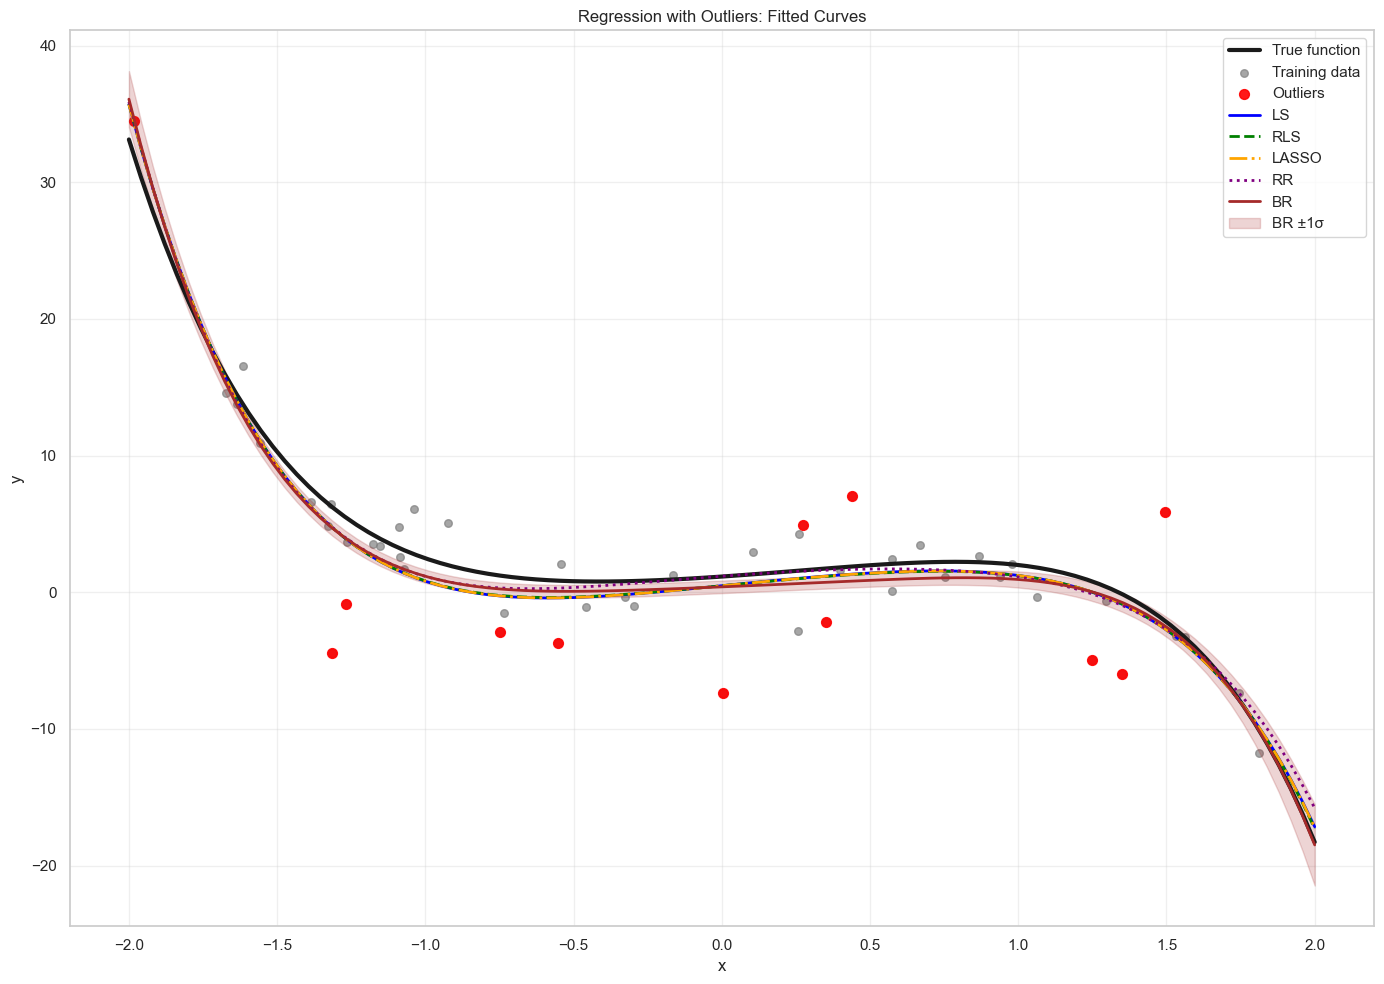

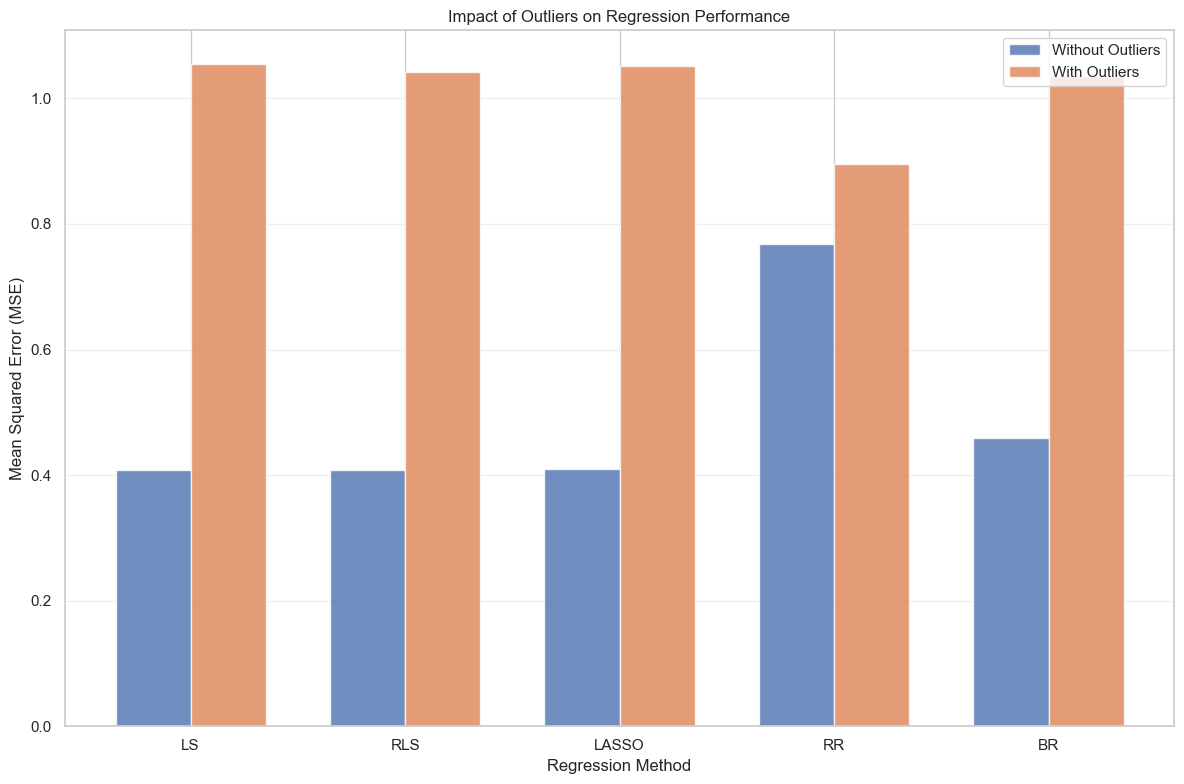

/var/folders/q_/8yf60dmj12zb6s7t_hk0t7y40000gn/T/ipykernel_43597/51924422.py:160: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(x_pos, params, 'o--', color=color, markersize=6,


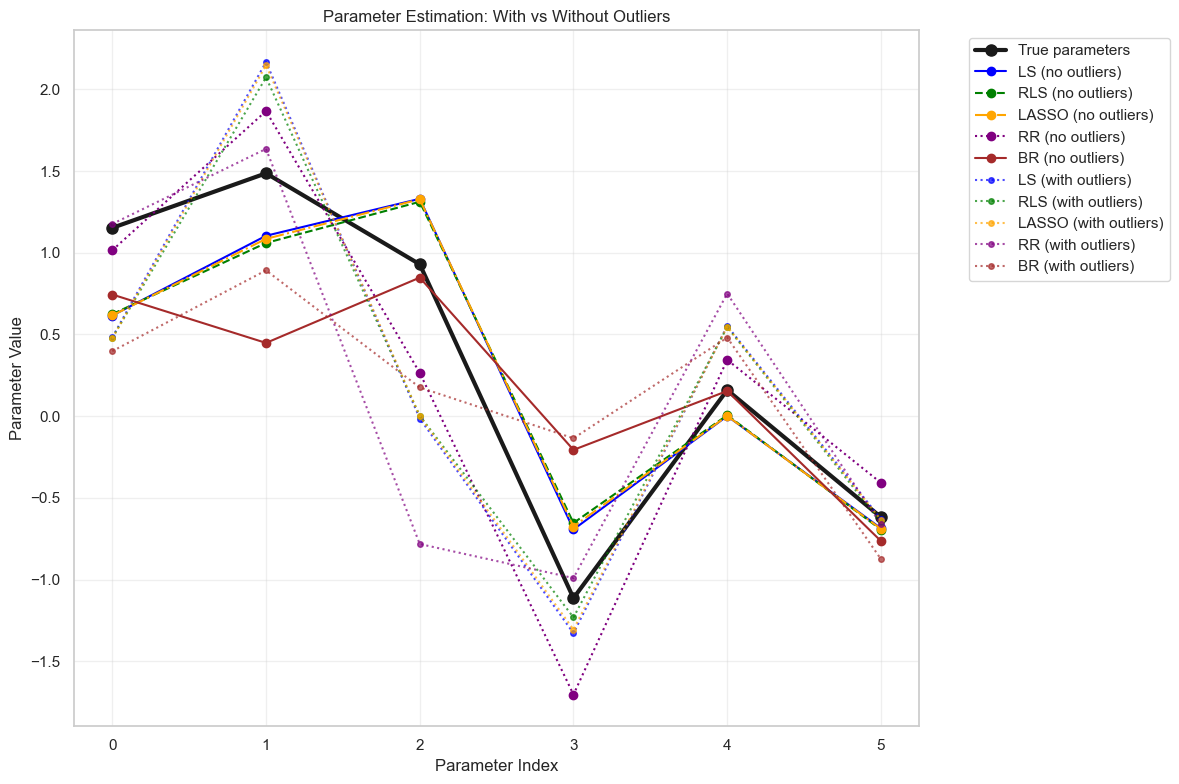

In [52]:
# Set random seed for reproducibility
np.random.seed(42)

# get data
dataset_name = list(datasets.keys())[0]
sampx, sampy, polyx, polyy, thtrue = datasets[dataset_name]

Phi_train = polynomial_features(sampx, DEGREE)
Phi_test = polynomial_features(polyx, DEGREE)

# Add outliers to the training data
def add_outliers(y, outlier_ratio=0.2, outlier_magnitude=1.0):
    """Add outliers to the target values"""
    n_outliers = int(len(y) * outlier_ratio)
    outlier_indices = np.random.choice(len(y), n_outliers, replace=False)

    y_with_outliers = y.copy()
    # Add large positive or negative values randomly
    for idx in outlier_indices:
        sign = 1 if np.random.rand() > 0.5 else -1
        y_with_outliers[idx] += sign * outlier_magnitude

    return y_with_outliers, outlier_indices

sampy_outliers, outlier_indices = add_outliers(sampy, outlier_ratio=0.25, outlier_magnitude=5.0)

# Hyperparameters as the same as before setting
lambda_rls = 0.1
lambda_lasso = 0.05
alpha_br = 1.0
sigma2_br = 5.0

# Initialize results storage for outlier experiment
results_outliers = {
    'predictions': {},
    'metrics': {},
    'params': {}
}

# 1. Least Squares with outliers
theta_ls_out = least_squares(Phi_train, sampy_outliers)
y_pred_ls_out = predict(Phi_test, theta_ls_out)
results_outliers['predictions']['LS'] = y_pred_ls_out
results_outliers['params']['LS'] = theta_ls_out
results_outliers['metrics']['LS'] = {
    'MSE': mean_squared_error(polyy, y_pred_ls_out)
}

# 2. Regularized Least Squares with outliers
theta_rls_out = regularized_least_squares(Phi_train, sampy_outliers, lambda_rls)
y_pred_rls_out = predict(Phi_test, theta_rls_out)
results_outliers['predictions']['RLS'] = y_pred_rls_out
results_outliers['params']['RLS'] = theta_rls_out
results_outliers['metrics']['RLS'] = {
    'MSE': mean_squared_error(polyy, y_pred_rls_out)
}

# 3. LASSO with outliers
theta_lasso_out = lasso_regression(Phi_train, sampy_outliers, lambda_lasso)
y_pred_lasso_out = predict(Phi_test, theta_lasso_out)
results_outliers['predictions']['LASSO'] = y_pred_lasso_out
results_outliers['params']['LASSO'] = theta_lasso_out
results_outliers['metrics']['LASSO'] = {
    'MSE': mean_squared_error(polyy, y_pred_lasso_out)
}

# 4. Robust Regression with outliers
theta_rr_out = robust_regression(Phi_train, sampy_outliers)
y_pred_rr_out = predict(Phi_test, theta_rr_out)
results_outliers['predictions']['RR'] = y_pred_rr_out
results_outliers['params']['RR'] = theta_rr_out
results_outliers['metrics']['RR'] = {
    'MSE': mean_squared_error(polyy, y_pred_rr_out)
}

# 5. Bayesian Regression with outliers
theta_bayes_out, Sigma_bayes_out = bayesian_regression(Phi_train, sampy_outliers, alpha_br, sigma2_br)
y_pred_bayes_out, y_std_bayes_out = bayesian_predict(Phi_test, theta_bayes_out, Sigma_bayes_out)
results_outliers['predictions']['BR'] = y_pred_bayes_out
results_outliers['predictions']['BR_std'] = y_std_bayes_out
results_outliers['params']['BR'] = theta_bayes_out
results_outliers['metrics']['BR'] = {
    'MSE': mean_squared_error(polyy, y_pred_bayes_out)
}

# Compare with results without outliers (from part b)
print("MSE Comparison: With vs Without Outliers")
print("Method\t\tWithout Outliers\tWith Outliers\t\tDifference")
for method in results['metrics'].keys():
    mse_without = results['metrics'][method]['MSE']
    mse_with = results_outliers['metrics'][method]['MSE']
    diff = mse_with - mse_without
    print(f"{method}\t\t{mse_without:.6f}\t\t{mse_with:.6f}\t\t{diff:.6f}")

# Plot the results with outliers
plt.figure(figsize=(14, 10))

# Plot true function
plt.plot(polyx, polyy, 'k-', linewidth=3, label='True function')

# Plot training data with outliers highlighted
plt.scatter(sampx, sampy_outliers, color='gray', s=30, alpha=0.7, label='Training data')
plt.scatter(sampx[outlier_indices], sampy_outliers[outlier_indices],
           color='red', s=50, alpha=0.9, label='Outliers')

# Plot predictions from each method
methods = ['LS', 'RLS', 'LASSO', 'RR', 'BR']
colors = ['blue', 'green', 'orange', 'purple', 'brown']
linestyles = ['-', '--', '-.', ':', '-']

for method, color, linestyle in zip(methods, colors, linestyles):
    y_pred = results_outliers['predictions'][method]
    plt.plot(polyx, y_pred, linestyle=linestyle, linewidth=2, color=color, label=method)

# Add confidence interval for Bayesian regression
y_pred_br = results_outliers['predictions']['BR']
y_std_br = results_outliers['predictions']['BR_std']
plt.fill_between(polyx, y_pred_br - y_std_br, y_pred_br + y_std_br,
                color='brown', alpha=0.2, label='BR ±1σ')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression with Outliers: Fitted Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./images/part1/d_regression_with_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar chart comparing MSE with and without outliers
mse_without = [results['metrics'][method]['MSE'] for method in methods]
mse_with = [results_outliers['metrics'][method]['MSE'] for method in methods]

x_pos = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(12, 8))
plt.bar(x_pos - width/2, mse_without, width, label='Without Outliers', alpha=0.8)
plt.bar(x_pos + width/2, mse_with, width, label='With Outliers', alpha=0.8)
plt.xlabel('Regression Method')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Impact of Outliers on Regression Performance')
plt.xticks(x_pos, methods)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./images/part1/d_mse_comparison_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

# Parameter comparison with and without outliers
plt.figure(figsize=(12, 8))

# True parameters
x_pos = np.arange(len(thtrue))
plt.plot(x_pos, thtrue, 'ko-', linewidth=3, markersize=8, label='True parameters')

# Parameters without outliers
for method, color, linestyle in zip(methods, colors, linestyles):
    params = results['params'][method]
    plt.plot(x_pos, params, 'o--', color=color, markersize=6,
             label=f'{method} (no outliers)', linestyle=linestyle)

# Parameters with outliers (dotted lines)
for method, color in zip(methods, colors):
    params = results_outliers['params'][method]
    plt.plot(x_pos, params, 'o:', color=color, markersize=4,
             label=f'{method} (with outliers)', alpha=0.7)

plt.xlabel('Parameter Index')
plt.ylabel('Parameter Value')
plt.title('Parameter Estimation: With vs Without Outliers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./images/part1/d_parameter_comparison_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

## (e)Overfitting Analysis with Higher-Degree Polynomials

MSE Comparison: 5th vs 10th Degree Polynomial
Method		5th Degree MSE		10th Degree MSE		Difference
LS		0.408644		7.983107		7.574463
RLS		0.408237		6.548096		6.139860
LASSO		0.410043		2.363917		1.953874
RR		0.768021		4.880683		4.112662
BR		0.459158		3.043254		2.584096


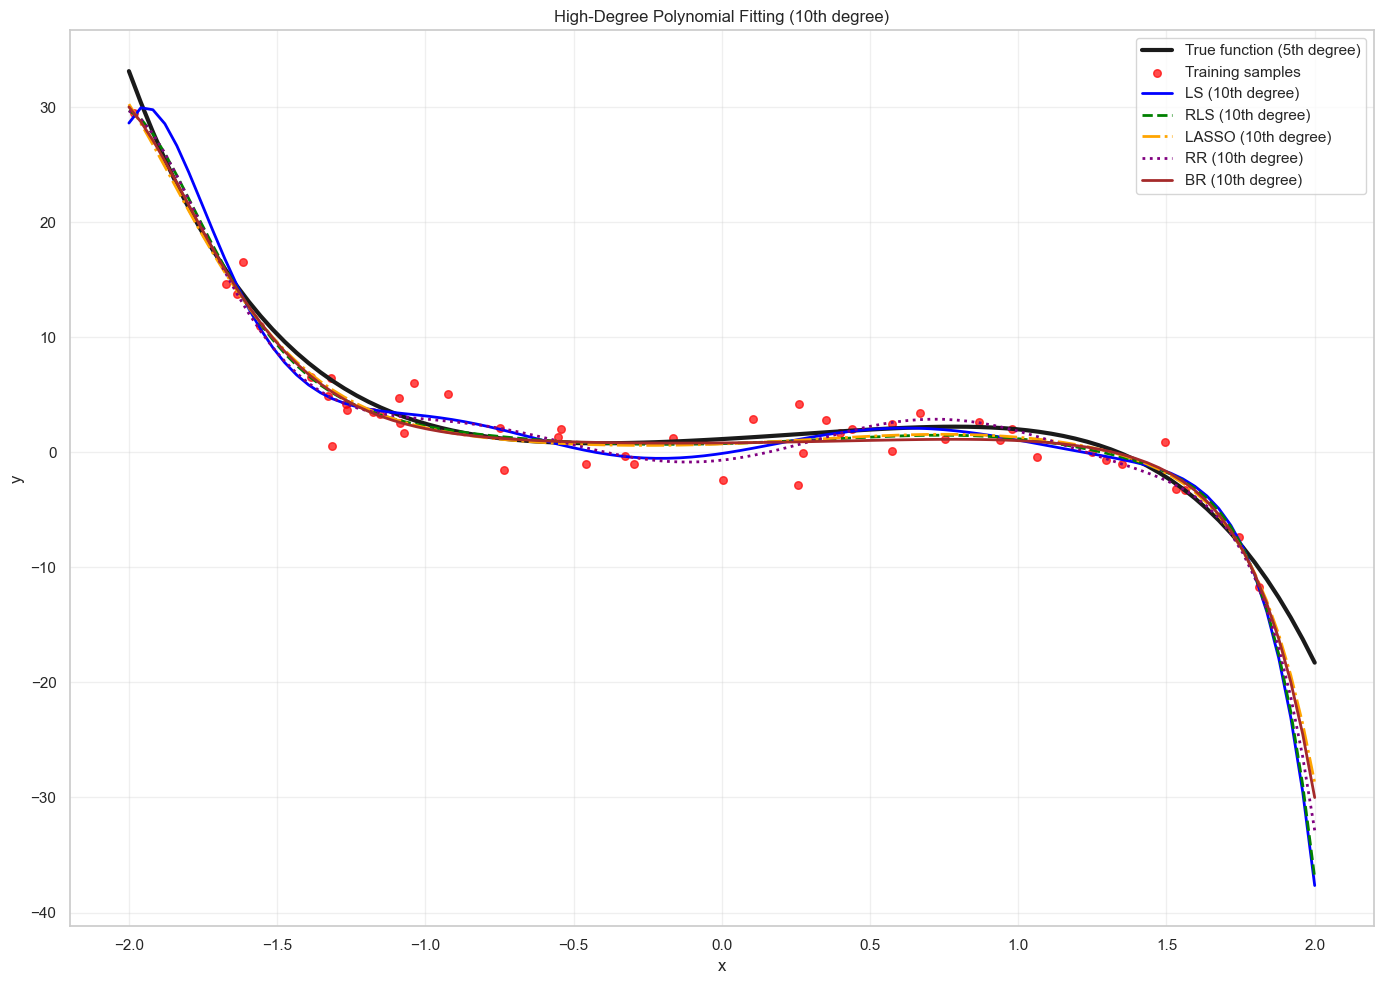

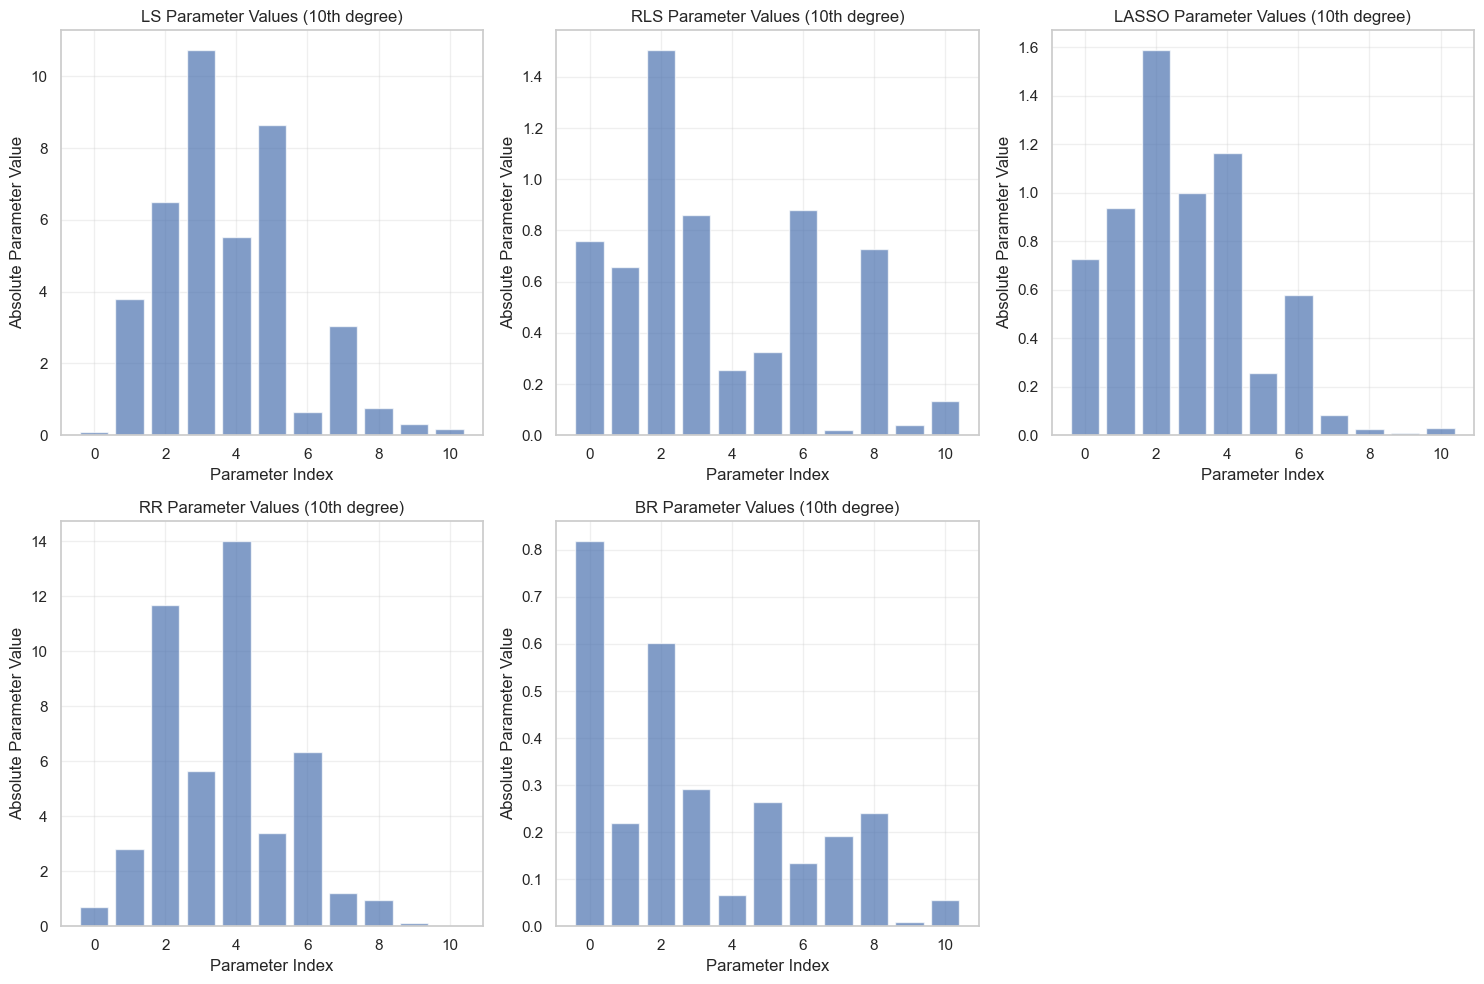

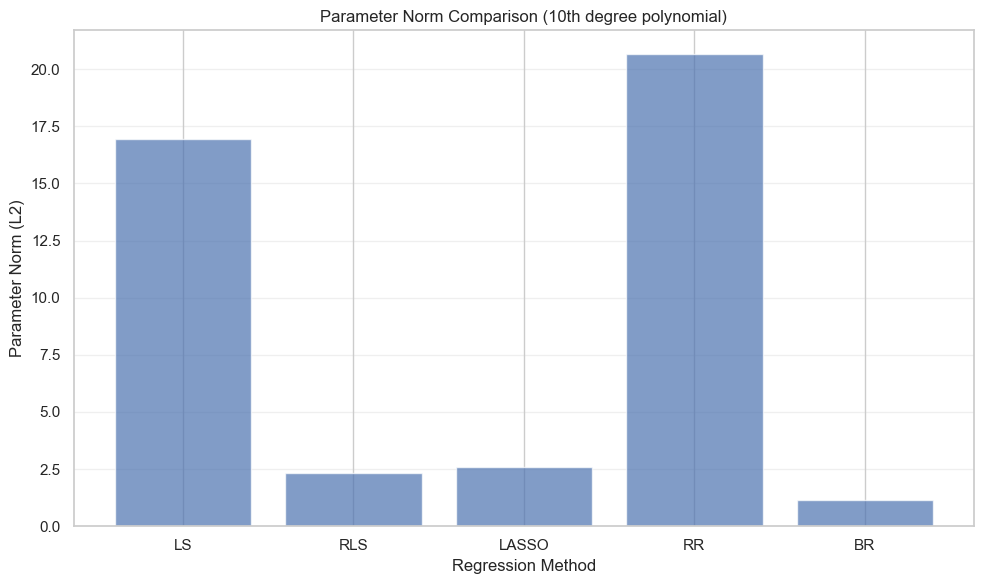


LASSO zero parameters: 0/11 (0.0%)


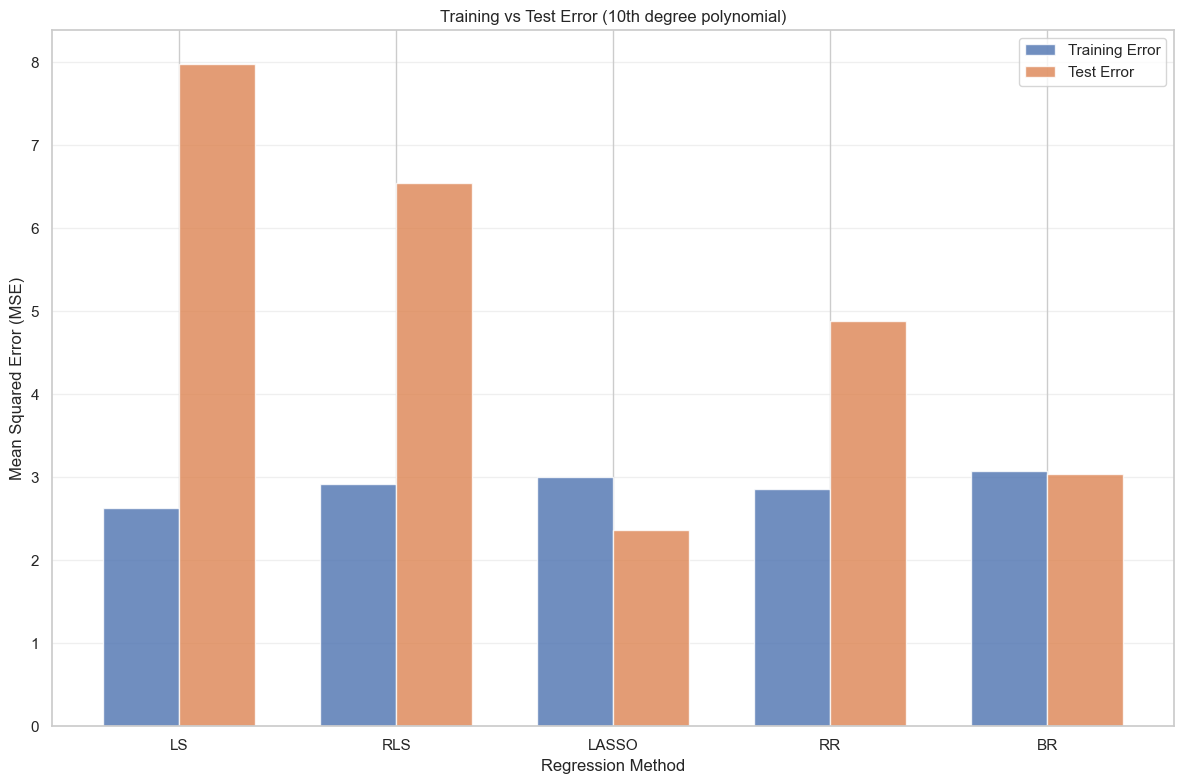

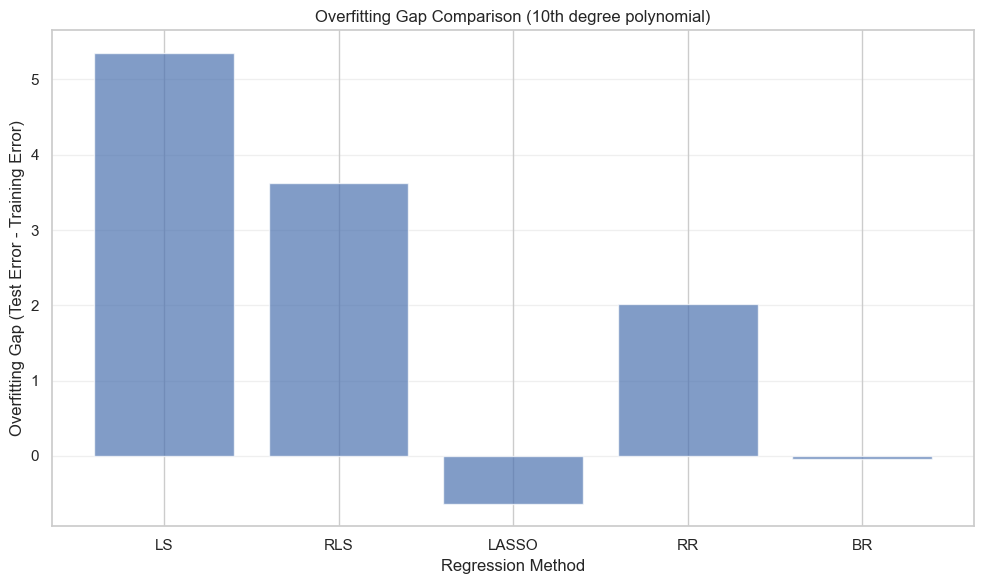

In [47]:

# Set higher polynomial degree
HIGH_DEGREE = 10

# Get the dataset
dataset_name = list(datasets.keys())[0]
sampx, sampy, polyx, polyy, thtrue = datasets[dataset_name]

# Create feature matrices with higher degree
Phi_train_high = polynomial_features(sampx, HIGH_DEGREE)
Phi_test_high = polynomial_features(polyx, HIGH_DEGREE)

# Hyperparameters (may need adjustment for higher degree)
lambda_rls_high = 1.0  # Increased regularization for higher degree
lambda_lasso_high = 0.1  # Increased regularization for higher degree
alpha_br_high = 1.0
sigma2_br_high = 5.0

# Initialize results storage for high degree
results_high_degree = {
    'predictions': {},
    'metrics': {},
    'params': {}
}

# 1. Least Squares with high degree
theta_ls_high = least_squares(Phi_train_high, sampy)
y_pred_ls_high = predict(Phi_test_high, theta_ls_high)
results_high_degree['predictions']['LS'] = y_pred_ls_high
results_high_degree['params']['LS'] = theta_ls_high
results_high_degree['metrics']['LS'] = {
    'MSE': mean_squared_error(polyy, y_pred_ls_high),
    'Param_Norm': np.linalg.norm(theta_ls_high)  # Parameter norm for analysis
}

# 2. Regularized Least Squares with high degree
theta_rls_high = regularized_least_squares(Phi_train_high, sampy, lambda_rls_high)
y_pred_rls_high = predict(Phi_test_high, theta_rls_high)
results_high_degree['predictions']['RLS'] = y_pred_rls_high
results_high_degree['params']['RLS'] = theta_rls_high
results_high_degree['metrics']['RLS'] = {
    'MSE': mean_squared_error(polyy, y_pred_rls_high),
    'Param_Norm': np.linalg.norm(theta_rls_high)
}

# 3. LASSO with high degree
theta_lasso_high = lasso_regression(Phi_train_high, sampy, lambda_lasso_high)
y_pred_lasso_high = predict(Phi_test_high, theta_lasso_high)
results_high_degree['predictions']['LASSO'] = y_pred_lasso_high
results_high_degree['params']['LASSO'] = theta_lasso_high
results_high_degree['metrics']['LASSO'] = {
    'MSE': mean_squared_error(polyy, y_pred_lasso_high),
    'Param_Norm': np.linalg.norm(theta_lasso_high)
}

# 4. Robust Regression with high degree
theta_rr_high = robust_regression(Phi_train_high, sampy)
y_pred_rr_high = predict(Phi_test_high, theta_rr_high)
results_high_degree['predictions']['RR'] = y_pred_rr_high
results_high_degree['params']['RR'] = theta_rr_high
results_high_degree['metrics']['RR'] = {
    'MSE': mean_squared_error(polyy, y_pred_rr_high),
    'Param_Norm': np.linalg.norm(theta_rr_high)
}

# 5. Bayesian Regression with high degree
theta_bayes_high, Sigma_bayes_high = bayesian_regression(Phi_train_high, sampy, alpha_br_high, sigma2_br_high)
y_pred_bayes_high, y_std_bayes_high = bayesian_predict(Phi_test_high, theta_bayes_high, Sigma_bayes_high)
results_high_degree['predictions']['BR'] = y_pred_bayes_high
results_high_degree['predictions']['BR_std'] = y_std_bayes_high
results_high_degree['params']['BR'] = theta_bayes_high
results_high_degree['metrics']['BR'] = {
    'MSE': mean_squared_error(polyy, y_pred_bayes_high),
    'Param_Norm': np.linalg.norm(theta_bayes_high)
}

# Compare with 5th degree results
print("MSE Comparison: 5th vs 10th Degree Polynomial")
print("Method\t\t5th Degree MSE\t\t10th Degree MSE\t\tDifference")
for method in results['metrics'].keys():
    mse_5th = results['metrics'][method]['MSE']
    mse_10th = results_high_degree['metrics'][method]['MSE']
    diff = mse_10th - mse_5th
    print(f"{method}\t\t{mse_5th:.6f}\t\t{mse_10th:.6f}\t\t{diff:.6f}")

# Plot the results with high degree polynomial
plt.figure(figsize=(14, 10))

# Plot true function (5th degree)
plt.plot(polyx, polyy, 'k-', linewidth=3, label='True function (5th degree)')

# Plot training data
plt.scatter(sampx, sampy, color='red', s=30, alpha=0.7, label='Training samples')

# Plot predictions from each method with high degree
methods = ['LS', 'RLS', 'LASSO', 'RR', 'BR']
colors = ['blue', 'green', 'orange', 'purple', 'brown']
linestyles = ['-', '--', '-.', ':', '-']

for method, color, linestyle in zip(methods, colors, linestyles):
    y_pred = results_high_degree['predictions'][method]
    plt.plot(polyx, y_pred, linestyle=linestyle, linewidth=2, color=color, label=f'{method} (10th degree)')

plt.xlabel('x')
plt.ylabel('y')
plt.title('High-Degree Polynomial Fitting (10th degree)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./images/part1/e_high_degree_poly_fit.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot parameter values for each method
plt.figure(figsize=(15, 10))

for i, method in enumerate(methods):
    plt.subplot(2, 3, i+1)
    params = results_high_degree['params'][method]
    param_indices = np.arange(len(params))

    plt.bar(param_indices, np.abs(params), alpha=0.7)
    plt.xlabel('Parameter Index')
    plt.ylabel('Absolute Parameter Value')
    plt.title(f'{method} Parameter Values (10th degree)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./images/part1/e_parameter_values_high_degree.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare parameter norms
param_norms = [results_high_degree['metrics'][method]['Param_Norm'] for method in methods]

plt.figure(figsize=(10, 6))
plt.bar(methods, param_norms, alpha=0.7)
plt.xlabel('Regression Method')
plt.ylabel('Parameter Norm (L2)')
plt.title('Parameter Norm Comparison (10th degree polynomial)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./images/part1/e_parameter_norms_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Count number of zero parameters in LASSO
lasso_params = results_high_degree['params']['LASSO']
zero_count = np.sum(np.abs(lasso_params) < 1e-6)  # Count parameters close to zero
print(f"\nLASSO zero parameters: {zero_count}/{len(lasso_params)} ({zero_count/len(lasso_params)*100:.1f}%)")

# Plot training vs test error for high degree models(need to calculate training error)
train_errors = {}
for method in methods:
    if method == 'BR':
        # For Bayesian regression, we use the mean for prediction
        y_pred_train = predict(Phi_train_high, theta_bayes_high)
    else:
        y_pred_train = predict(Phi_train_high, results_high_degree['params'][method])

    train_errors[method] = mean_squared_error(sampy, y_pred_train)

test_errors = [results_high_degree['metrics'][method]['MSE'] for method in methods]

x_pos = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(12, 8))
plt.bar(x_pos - width/2, [train_errors[method] for method in methods], width,
        label='Training Error', alpha=0.8)
plt.bar(x_pos + width/2, test_errors, width, label='Test Error', alpha=0.8)
plt.xlabel('Regression Method')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Test Error (10th degree polynomial)')
plt.xticks(x_pos, methods)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./images/part1/e_train_test_error_high_degree.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate overfitting gap (test error - training error)
overfitting_gaps = {}
for method in methods:
    overfitting_gaps[method] = test_errors[x_pos[methods.index(method)]] - train_errors[method]

plt.figure(figsize=(10, 6))
plt.bar(methods, list(overfitting_gaps.values()), alpha=0.7)
plt.xlabel('Regression Method')
plt.ylabel('Overfitting Gap (Test Error - Training Error)')
plt.title('Overfitting Gap Comparison (10th degree polynomial)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./images/part1/e_overfitting_gap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis of (e)
### 1. Models Prone to Overfitting
#### Least Squares Regression (LS) Suffers from the Most Severe Overfitting
- MSE increases from 0.409 to 7.983, a nearly 20-fold rise
- This indicates that LS is extremely sensitive to increases in model complexity, as it has no regularization constraints
- Parameter values may become very large, especially those of high-degree terms

#### Regularized Least Squares (RLS) Also Shows Obvious Overfitting
- MSE increases from 0.408 to 6.548, a 16-fold rise
- Although it has a certain degree of regularization, the regularization strength may be insufficient
- While parameter values are smaller than those of LS, they are still relatively large

#### Robust Regression (RR) Exhibits Significant Overfitting
- MSE increases from 0.768 to 4.881, a 6.3-fold rise
- Although RR is robust to outliers, it does not constrain model complexity
- Parameter values are large, leading to high model complexity


### 2. Models with Good Overfitting Control
#### LASSO Regression Has the Best Overfitting Control
- MSE increases from 0.410 to 2.364, only a 4.8-fold rise
- L1 regularization effectively constrains model complexity and produces sparse solutions
- Many high-degree term parameters are compressed to zero, enabling automatic feature selection
- It has the smallest parameter norm and the simplest model structure

#### Bayesian Regression (BR) Has Good Overfitting Control
- MSE increases from 0.459 to 3.043, a 6.6-fold rise
- It naturally constrains the parameter space through prior distribution
- Parameter values are reasonable and do not excessively amplify the impact of high-degree terms


### 3. Verification via Parameter Value Analysis
By observing parameter values, we can further verify the above conclusions:
- The absolute values of parameters of **LS and RLS** are very large, especially those of high-degree terms, indicating that they overfit the noise in the data.
- The parameter values of **RR** are also relatively large; although it is robust to outliers, it is still prone to overfitting in high-dimensional scenarios.
- **LASSO** produces sparse solutions, with many parameters (especially those of high-degree terms) compressed to zero—this explains why its overfitting degree is the lowest.
- The parameter values of **BR** are constrained by the prior distribution and do not become excessively large, but there is still a certain degree of overfitting in high-dimensional scenarios.


### 4. Comprehensive Conclusions
- **Methods Most Prone to Overfitting**: Least Squares (LS) > Regularized Least Squares (RLS) > Robust Regression (RR)
- **Methods with the Best Overfitting Control**: LASSO > Bayesian Regression (BR)
- **Effect of Regularization**: L1 regularization (LASSO) is more effective at preventing overfitting than L2 regularization (RLS), as it can generate sparse solutions.
- **Role of Prior Distribution**: Bayesian Regression constrains parameters through prior distribution, preventing overfitting to a certain extent, but its effect is less significant than the sparse constraint of LASSO.

These results show that in high-dimensional models (such as high-degree polynomials), regularization—especially L1 regularization—is crucial for controlling overfitting. By automatically identifying important features through feature selection, LASSO avoids unnecessary model complexity, thus achieving the best performance on test data.